# Workbook:

This notebook covers exploratory data analysis, experimental models, unofficial feature extraction (not used in the final model), and other workflow-related activities.

For the final model and report, please refer to my [final_notebook](final_notebook.ipynb).

## Business Understanding

This project aims to solve the problem of automatically classifying musical chords as either major or minor using audio input. Chord identification is a key task in music analysis, and automating it can save time on transcription and harmonic analysis. By using machine learning and music information retrieval (MIR) techniques, the goal is to create a tool that helps musicians, producers, and educators analyze music in real-time. The project focuses on making chord recognition more accessible and efficient, benefiting both students and professionals in the music industry.

---

## Tools/Methodologies

To handle the workflow, I'll use several Python libraries:

- [librosa](https://librosa.org/doc/latest/index.html) for extracting audio features, [numpy](https://numpy.org/doc/1.24/reference/index.html#reference) and [pandas](https://pandas.pydata.org/docs/reference/index.html#api) for data manipulation, and os and [Kaggle CLI](https://www.kaggle.com/code/donkeys/kaggle-python-api) to download the data directly into the notebook.
- [matplotlib](https://matplotlib.org/stable/api/index.html) and [seaborn](https://seaborn.pydata.org/api.html) for exploring and visualizing features like waveforms and spectrograms.
- [scikit-learn](https://scikit-learn.org/stable/api/index.html) for baseline models (e.g., logistic regression, SVM), and [tensorflow](https://www.tensorflow.org/api_docs/python/tf/all_symbols) or [keras](https://keras.io/api/) for building CNNs.

In [1]:
# Data manipulation
import numpy as np
import pandas as pd
import itertools
import sklearn
import random
import pickle
import time
import json
import os

# Audio feature extraction
import librosa
import librosa.display
import soundfile as sf
from statsmodels.stats.multitest import multipletests
from scipy.signal import find_peaks
from scipy import stats

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Machine learning models and utilities
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.impute import KNNImputer
from sklearn.dummy import DummyClassifier

# Deep learning for CNNs
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Conv2D, MaxPooling2D, Flatten, Dense, Reshape, Dropout, GlobalAveragePooling2D, TimeDistributed
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

# Ignore warnings from specific modules
warnings.filterwarnings("ignore", category=UserWarning, module="librosa")
warnings.filterwarnings("ignore", category=FutureWarning, module="librosa")
warnings.filterwarnings("ignore", message="PySoundFile failed. Trying audioread instead.")
warnings.filterwarnings("ignore", message="Couldn't find ffmpeg or avconv")

## Data Understanding
The dataset used in this project is sourced from the [Musical Instrument Chord Classification (Audio)](https://www.kaggle.com/datasets/deepcontractor/musical-instrument-chord-classification) dataset on Kaggle. It contains audio files `.wav` format of chords played on two instruments: guitar and piano. The raw data has been scraped from various sources and is already available for download on Kaggle, eliminating the need for manual data collection. The dataset is well-suited for this project, as it provides a clear distinction between major and minor chords, which is the focus of the classification task.

The features for the model will be extracted from the audio files using techniques such as Mel-frequency cepstral coefficients (MFCCs) or spectrograms, which capture important frequency and temporal information from the audio signals. Although other individuals may have used this dataset for similar chord classification tasks, this project will build upon existing work by focusing specifically on distinguishing between major and minor chords, potentially improving upon current models or exploring new machine learning techniques for this type of classification.

In [2]:
# uncomment if replicating project
# !pip install kaggle

In [3]:
# Function to authenticate using Kaggle credentials
def authenticate_kaggle_api(kaggle_json_path: str = None, kaggle_username: str = None, kaggle_key: str = None):
    """
    Authenticate Kaggle API to allow dataset download.
    
    Tries the following in order:
    1. Use kaggle.json file if available.
    2. Use provided kaggle_username and kaggle_key if provided.
    3. Use environment variables if set.

    Parameters:
    kaggle_json_path (str): Path to kaggle.json (default is None).
    kaggle_username (str): Kaggle username (optional if kaggle.json is used).
    kaggle_key (str): Kaggle API key (optional if kaggle.json is used).
    """
    if kaggle_json_path and os.path.exists(kaggle_json_path):
        print(f"Authenticating using kaggle.json at {kaggle_json_path}")
        with open(kaggle_json_path, 'r') as f:
            kaggle_config = json.load(f)
            os.environ['KAGGLE_USERNAME'] = kaggle_config['username']
            os.environ['KAGGLE_KEY'] = kaggle_config['key']
    elif kaggle_username and kaggle_key:
        print("Authenticating using provided username and key.")
        os.environ['KAGGLE_USERNAME'] = kaggle_username
        os.environ['KAGGLE_KEY'] = kaggle_key
    else:
        print("Using environment variables for Kaggle API authentication.")
    
    # Authenticate Kaggle API
    api = KaggleApi()
    api.authenticate()
    return api

# Function to download and extract dataset
def download_dataset(api, dataset_name: str, destination_dir: str):
    """
    Download and extract the dataset using Kaggle API.

    Parameters:
    api: KaggleApi instance.
    dataset_name (str): Name of the dataset to download.
    destination_dir (str): Directory to save the dataset.
    """
    os.makedirs(destination_dir, exist_ok=True)
    api.dataset_download_files(dataset_name, path=destination_dir, unzip=True)
    print("Dataset downloaded and extracted to:", destination_dir)


In [4]:
# Kaggle API for dataset download
from kaggle.api.kaggle_api_extended import KaggleApi

# Authenticate and download Kaggle dataset
api = authenticate_kaggle_api(kaggle_json_path='kaggle.json')

# If you don't have kaggle.json, use the following alternative to authenticate with credentials
# api = authenticate_kaggle_api(kaggle_username='your_kaggle_username', kaggle_key='your_kaggle_api_key')

# Download a dataset (example)
dataset_name = 'deepcontractor/musical-instrument-chord-classification'
dataset_dir = './dataset'
download_dataset(api, dataset_name, dataset_dir)

Authenticating using kaggle.json at kaggle.json
Dataset URL: https://www.kaggle.com/datasets/deepcontractor/musical-instrument-chord-classification
Dataset downloaded and extracted to: ./dataset


In [5]:
def load_audio_file_details(base_dir: str) -> pd.DataFrame:
    """
    Load details of audio files from specified directory.

    Parameters:
    base_dir (str): Base directory containing audio files.

    Returns:
    pd.DataFrame: DataFrame containing file paths, ids, and labels.
    """
    file_details = []
    for category in ['Major', 'Minor']:
        category_dir = os.path.join(base_dir, category)
        for filename in os.listdir(category_dir):
            if filename.endswith('.wav'):
                file_details.append({'path': os.path.join(category_dir, filename), 'id': filename, 'label': category})
    return pd.DataFrame(file_details)

In [6]:
base_dir = os.path.join(dataset_dir, 'Audio_Files')
file_data = load_audio_file_details(base_dir)
print(file_data.head())

                                        path             id  label
0    ./dataset\Audio_Files\Major\Major_0.wav    Major_0.wav  Major
1    ./dataset\Audio_Files\Major\Major_1.wav    Major_1.wav  Major
2   ./dataset\Audio_Files\Major\Major_10.wav   Major_10.wav  Major
3  ./dataset\Audio_Files\Major\Major_100.wav  Major_100.wav  Major
4  ./dataset\Audio_Files\Major\Major_101.wav  Major_101.wav  Major


## Music and Math

Each musical note corresponds to a fundamental frequency - the lowest frequency of a note that is musically pleasing. This frequency is what characterizes the note, which is represented by letters ['A', 'B', 'C', 'D', 'E', 'F', 'G']. 

#### Frequency:

The frequency \( f \) of a note can be calculated with the following formula:

$$ f = f_0 \times 2^{\frac{n}{12}} $$

Where:
- `f_0` is the frequency of a reference note (usually the note **A4**, which is **440 Hz**).
- `n` is the number of half-steps away from the reference note. Positive values of `n` indicate higher notes, while negative values indicate lower notes.

The standard practice in determining the closest note to a given frequency generally involves finding which standard note frequency it's nearest to.

#### Harmonics

A single note played on an instrument does not produce just one frequency. For example, playing an 'A' at 220 Hz will generate additional frequencies at 440 Hz, 660 Hz, 880 Hz, 1100 Hz, and so on. According to this [Music Note Frequency Chart](https://mixbutton.com/mixing-articles/music-note-to-frequency-chart/) the frequencies 220, 440, and 880 Hz correspond to the musical notes A3, A4, and A5, respectively. These notes are all 'A' notes, each one octave apart. The lowest harmonic, known as the fundamental frequency, determines the perceived pitch of the sound.

> In standard musical pitch, A4, or the fourth octave 'A', is tuned to 440 Hz.

Interestingly, the frequency 1100 Hz falls between the frequencies for B5 (987.77 Hz) and C6 (1046.50 Hz). Calculating the midpoint between these two frequencies gives:

$$
\text{Midpoint} = \frac{987.77 \, \text{Hz} + 1046.50 \, \text{Hz}}{2} = 1017.135 \, \text{Hz}
$$

Since 1100 Hz is closer to 1046.50 Hz than to 987.77 Hz, it would be classified closer to C6 in standard musical pitch, though it is somewhat sharper than a typical B5. This illustrates how harmonics work in physical instruments, where playing a fundamental note also produces these higher frequencies, contributing to the richness of the instrument's sound.

#### Chords

A chord represents a combination of several notes played simultaneously, resulting in a harmonious sound. This harmony is achieved through the specific relationship of the frequencies of the notes within the chord. For instance, a simple major chord is composed of the root note, a major third above the root, and a perfect fifth above the root, creating a full and bright sound typically associated with major chords.

Minor chords, on the other hand, are formed by the root note, a minor third above the root, and a perfect fifth above the root, delivering a more melancholic or somber tone compared to major chords.

In addition to major and minor chords, two other common types are diminished and augmented chords. A diminished chord is made up of the root note, a minor third, and a diminished fifth, giving it a tense and unstable sound. An augmented chord consists of the root note, a major third, and an augmented fifth, which creates a sense of suspense or unresolved tension.

#### FourierTransforms

A Fourier transform is a powerful mathematical tool that transforms a signal from its original domain (often time or space) into a frequency domain. This transformation allows us to dissect complex signals and understand how different frequencies contribute to the overall signal. Essentially, it breaks down a wave-like signal into its individual components, highlighting the frequencies that are present.

Why does this help us? Well, by using a Fourier transform, we can analyze various aspects of signals that are not immediately apparent in the time domain. For example, in music production, it helps us identify the specific frequencies that make up a sound, which is crucial for tasks like mixing, mastering, or even sound design. This analysis provides insights into the pitch, tone, and timbre of sounds, helping audio engineers and musicians make informed decisions to enhance musical pieces.

In essence, the Fourier transform is a bridge between the time domain and the frequency domain, providing a comprehensive look at the frequencies that influence a signal. This capability makes it an indispensable tool in fields ranging from audio processing to telecommunications and beyond.

Using a frequency chart to analyze these chords would reveal a complex spectrum due to the concurrent presence of multiple notes. Each note in a chord contributes its fundamental frequency along with its harmonics, leading to a dense array of spikes on the chart. This complex interplay of frequencies helps to understand why chords have their distinctive sounds and emotional impacts.

### Spectogram

A **spectrogram** is a visual representation of the spectrum of frequencies in a sound or other signal as they vary with time. It's essentially a graph that shows the intensity (or loudness) of various frequencies over a period of time. The horizontal axis of a spectrogram represents time, the vertical axis represents frequency, and the colors or shades on the graph indicate the amplitude or strength of the frequencies at any given time. 

#### Why are they useful?

- **Analysis of Sounds**: Spectrograms are incredibly useful for analyzing the characteristics of different sounds, making them indispensable in fields like music production, linguistics, and sound engineering. They help identify variations in frequency that occur over time, which can be crucial for understanding speech patterns, musical notes, and environmental sounds.
- **Signal Processing**: In signal processing, spectrograms provide a clear visualization of how frequencies change, aiding in the enhancement or isolation of specific sounds within a mixed signal.
- **Troubleshooting**: They are also used to diagnose issues in machinery or systems by detecting unusual frequency patterns, which often indicate malfunctions.

In [7]:
# !pip install pydub # if needed when running in Google Colab

In [8]:
from IPython.display import Audio
from pydub import AudioSegment
from pydub.playback import play
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile


In [9]:
class AudioAnalyzer:
    def __init__(self, df):
        self.df = df

    def play_audio(self, file_id):
        """
        Finds the file path from the file_id, loads, and plays the audio or displays a player.
        
        Parameters:
        file_id (str): The filename (e.g., 'Major_123.wav').
        """
        # Find the row in the DataFrame with the matching file_id
        file_row = self.df[self.df['id'] == file_id]
        
        if not file_row.empty:
            # Get the full path of the audio file
            file_path = file_row.iloc[0]['path']
            
            try:
                print(f"Playing audio: {file_path}")
                # Display an embedded audio player in Jupyter (rather than just playing it)
                return Audio(filename=file_path, autoplay=False)
            except Exception as e:
                print(f"Error playing audio: {e}")
        else:
            print(f"File with id {file_id} not found in file_data.")

    def plot_audio(self, file_id, max_freq=None):
        """
        Plots the time and frequency domain of the audio file.
        
        Parameters:
        file_id (str): The filename (e.g., 'Major_123.wav').
        max_freq (float): Maximum frequency to display in the frequency domain plot.
        """
        # Find the row in the DataFrame with the matching file_id
        file_row = self.df[self.df['id'] == file_id]

        if not file_row.empty:
            filename = file_row.iloc[0]['path']
            
            # Read the audio file
            samplerate, data = wavfile.read(filename)
            times = np.arange(len(data)) / float(samplerate)
            
            # Plot time domain data
            plt.figure(figsize=(16, 6))
            plt.subplot(1, 2, 1)
            plt.title("Time Domain")
            plt.xlabel("Time [s]")
            plt.ylabel("Amplitude")
            plt.plot(times, data)
            
            # Compute and plot frequency domain data
            fft_data = np.fft.fft(data)
            freqs = np.fft.fftfreq(len(fft_data), 1/samplerate)
            magnitude = np.abs(fft_data)[:len(data)//2]
            freqs = freqs[:len(data)//2]
            
            plt.subplot(1, 2, 2)
            plt.title("Frequency Domain")
            plt.xlabel("Frequency [Hz]")
            plt.ylabel("Magnitude")
            if max_freq is not None:
                plt.xlim([0, max_freq])
            plt.plot(freqs, magnitude)
            plt.show()
        else:
            print(f"File with id {file_id} not found in file_data.")
        
    def plot_spectrogram(self, file_id, max_freq=None):
        row = self.df.iloc[file_id]
        filename = row['path']
        signal, sr = librosa.load(filename, sr=None)  # Load with the original sample rate

        # Generate the spectrogram
        D = librosa.amplitude_to_db(np.abs(librosa.stft(signal)), ref=np.max)

        # Plotting the spectrogram
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
        if max_freq is not None:
            plt.ylim([0, max_freq])
        plt.colorbar(format='%+2.0f dB')
        plt.title('Spectrogram')
        plt.xlabel('Time')
        plt.ylabel('Frequency (Hz)')
        plt.tight_layout()
        plt.show()
        
    def plot_mel_spectrogram(self, file_id, n_mels=128, max_freq=None):
        row = self.df.iloc[file_id]
        filename = row['path']
        signal, sr = librosa.load(filename, sr=None)

        # Generate Mel-spectrogram
        mel_spectrogram = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=n_mels)
        log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

        # Plotting the Mel-spectrogram
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(log_mel_spectrogram, sr=sr, x_axis='time', y_axis='mel', fmax=max_freq)
        plt.colorbar(format='%+2.0f dB')
        plt.title('Mel-Spectrogram')
        plt.tight_layout()
        plt.show()

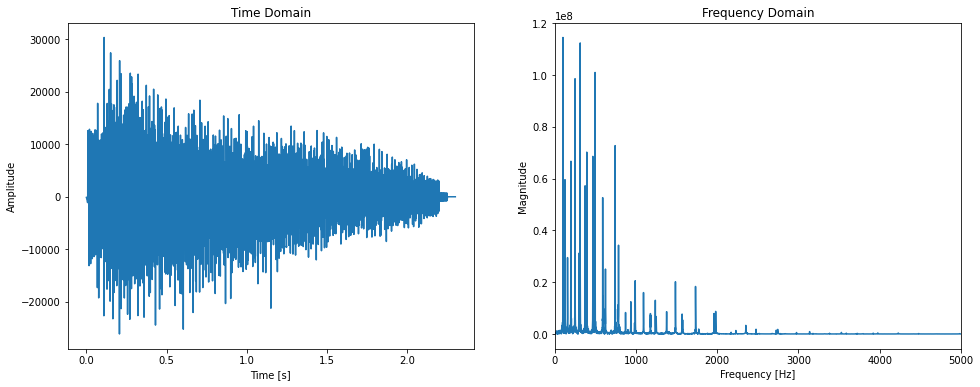

Playing audio: ./dataset\Audio_Files\Major\Major_222.wav


In [10]:
analyzer = AudioAnalyzer(file_data)
file_id = "Major_222.wav"

# Plot the audio
analyzer.plot_audio(file_id, max_freq=5000)

# Play the audio
audio_player = analyzer.play_audio(file_id)
audio_player



---

## Data Preparation

The dataset consists of raw .wav files, so no traditional tabular data is available. Preprocessing will involve extracting features like MFCCs, spectrograms, or chroma features to transform the audio into usable data. Challenges include ensuring that these features correctly capture the harmonic information while handling variations in recording quality and instrument type. We estimate several hundred rows of data, each representing an individual chord sample. Visualizations like waveform plots and spectrograms will be used to explore the features that distinguish major from minor chords.

### Extract Features

#### Audio features:

Using the `extract_audio_features` method, we extracted and structured chroma, MFCC, spectral centroid, and zero-crossing rate features. 

We will also ensure these features are properly aligned with the data format needed for the CNN + LSTM model.

#### Harmonics and Intervals

Using the find_harmonics and selected features from our [Feature Engineering] section

#### Encode Labels
Our target feature 'label' should be converted into a numerical format.
> 0: Major 
> 1: Minor

In [11]:
def extract_audio_features(signal=None, sr=22050, hop_length=512, n_fft=2048):
    if signal is None or not isinstance(signal, np.ndarray):
        print("Warning: No valid audio signal provided.")
        return {
            'chroma': np.full(12, np.nan),
            'mfcc': np.full(20, np.nan),
            'spectral_centroid': np.nan,
            'zero_crossing_rate': np.nan
        }

    try:
        chroma = librosa.feature.chroma_stft(y=signal, sr=sr, hop_length=hop_length, n_fft=n_fft).mean(axis=1)
        mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=20, hop_length=hop_length, n_fft=n_fft).mean(axis=1)
        spectral_centroid = librosa.feature.spectral_centroid(y=signal, sr=sr, hop_length=hop_length).mean()
        zero_crossing_rate = librosa.feature.zero_crossing_rate(signal, hop_length=hop_length).mean()

        return {
            'chroma': chroma,
            'mfcc': mfccs,
            'spectral_centroid': spectral_centroid,
            'zero_crossing_rate': zero_crossing_rate
        }

    except Exception as e:
        print(f"Error during feature extraction: {e}")
        return {
            'chroma': np.full(12, np.nan),
            'mfcc': np.full(20, np.nan),
            'spectral_centroid': np.nan,
            'zero_crossing_rate': np.nan
        }

In [12]:
def find_harmonics(signal=None, sr=22050, n_fft=2048):
    try:
        if signal is None or len(signal) == 0:
            raise ValueError("No audio signal provided.")

        S = np.abs(librosa.stft(signal, n_fft=n_fft))
        magnitude = np.mean(S, axis=1)
        frequency = np.fft.fftfreq(len(magnitude), 1/sr)
        positive_freq_idxs = np.where(frequency >= 0)
        positive_freqs = frequency[positive_freq_idxs]
        positive_magnitude = magnitude[positive_freq_idxs]

        peaks, _ = find_peaks(positive_magnitude, height=np.max(positive_magnitude) * 0.1)
        harmonic_frequencies = positive_freqs[peaks]
        harmonic_intervals = np.diff(harmonic_frequencies) if len(harmonic_frequencies) > 1 else []

        return harmonic_frequencies, harmonic_intervals

    except Exception as e:
        print(f"Error processing harmonics for augmented signal: {e}")
        return None, None

In [13]:
def extract_mel_spectrogram(signal=None, sr=22050, n_mels=128, hop_length=512, fixed_length=100):
    if signal is None or not isinstance(signal, np.ndarray):
        print("Warning: No valid audio signal provided for mel-spectrogram extraction.")
        return np.full((fixed_length, n_mels), np.nan)

    try:
        mel_spectrogram = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=n_mels, hop_length=hop_length)
        log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
        log_mel_spectrogram = log_mel_spectrogram.T

        if log_mel_spectrogram.shape[0] < fixed_length:
            pad_width = fixed_length - log_mel_spectrogram.shape[0]
            log_mel_spectrogram = np.pad(log_mel_spectrogram, ((0, pad_width), (0, 0)), mode='constant')
        else:
            log_mel_spectrogram = log_mel_spectrogram[:fixed_length, :]

        return log_mel_spectrogram

    except Exception as e:
        print(f"Error during Mel-spectrogram extraction: {e}")
        return np.full((fixed_length, n_mels), np.nan)

In [14]:
def extract_audio_signal(path, sr=None):
    try:
        signal, sr = librosa.load(path, sr=sr)
        return signal, sr
    except Exception as e:
        print(f"Error loading audio from {path}: {e}")
        return None, None


#### Running Feature Extraction on Dataset:

In [15]:
def extract_features_from_signals(data, feature_toggles):
    feature_dict_list = []

    for index, row in data.iterrows():
        try:
            # Extract audio signal
            signal, sr = extract_audio_signal(row['path'])
            if signal is None:
                continue  # Skip if signal is not available

            # Initialize the feature dictionary with basic info
            feature_dict = {'id': row['id'], 'Label': row['label'], 'audio_signal': signal}

            # Extract features based on toggles
            if feature_toggles.get('chroma', False):
                feature_dict.update({'chroma': extract_audio_features(signal, sr)['chroma']})
            if feature_toggles.get('mfcc', False):
                feature_dict.update({'mfcc': extract_audio_features(signal, sr)['mfcc']})
            if feature_toggles.get('spectral_centroid', False):
                feature_dict['spectral_centroid'] = extract_audio_features(signal, sr)['spectral_centroid']
            if feature_toggles.get('zero_crossing_rate', False):
                feature_dict['zero_crossing_rate'] = extract_audio_features(signal, sr)['zero_crossing_rate']
            if feature_toggles.get('harmonics', False):
                harmonics, intervals = find_harmonics(signal, sr)
                feature_dict['harmonics'] = harmonics
                feature_dict['intervals'] = intervals
            if feature_toggles.get('mel_spectrogram', False):
                mel_spectrogram = extract_mel_spectrogram(signal, sr)
                feature_dict['mel_spectrogram'] = mel_spectrogram.flatten()

            # Extract comprehensive harmonic ratios for major/minor classification
            if feature_toggles.get('harmonic_ratios', False):
                harmonic_ratios = extract_comprehensive_harmonic_ratios(signal, sr)
                feature_dict.update(harmonic_ratios)

            # Append the dictionary to the list
            feature_dict_list.append(feature_dict)

        except Exception as e:
            print(f"Error processing file {row['path']}: {e}")

    return pd.DataFrame(feature_dict_list)

In [17]:
# Feature Toggles
feature_toggles = {
    'chroma': True,
    'mfcc': True,
    'spectral_centroid': True,
    'zero_crossing_rate': True,
    'harmonics': True,
    'mel_spectrogram': True,
}

# Extract Features for All Data
raw_features_df = extract_features_from_signals(file_data, feature_toggles)
raw_features_df['id'] = raw_features_df['id'].str.replace('.wav', '', regex=False)
raw_features_df['Label'] = raw_features_df['Label'].str.lower()

# Display Resulting DataFrame
print("Extracted Features DataFrame:")
print(raw_features_df.head())

Error loading audio from ./dataset\Audio_Files\Major\Major_285.wav: 
Extracted Features DataFrame:
          id  Label                                       audio_signal  \
0    Major_0  major  [-0.004333496, -0.0058898926, -0.0048217773, -...   
1    Major_1  major  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2   Major_10  major  [-0.004333496, -0.0058898926, -0.0048217773, -...   
3  Major_100  major  [-0.0062561035, -0.008087158, -0.007171631, -0...   
4  Major_101  major  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                              chroma  \
0  [0.7968521, 0.41725653, 0.2998105, 0.39145, 0....   
1  [0.7232829, 0.45263815, 0.26252756, 0.23647432...   
2  [0.37183326, 0.2676605, 0.1256456, 0.14466327,...   
3  [0.39077398, 0.9342459, 0.7632381, 0.55300677,...   
4  [0.20732851, 0.4035183, 0.40069222, 0.4611866,...   

                                                mfcc  spectral_centroid  \
0  [-338.3117, 257.16064, 37.91532, -19.9110

In [18]:
# Validation Step: Count Zero and Non-Zero Values for Raw Data
print("Validation of Feature Counts in raw_features_df:")

for column in raw_features_df.columns:
    # For numeric scalar columns
    if pd.api.types.is_numeric_dtype(raw_features_df[column]):
        zero_count = (raw_features_df[column] == 0).sum()
        non_zero_count = (raw_features_df[column] != 0).sum()

        # Print only if there are more than one 'zero count'
        if zero_count > 1:
            print(f"Feature '{column}':")
            print(f"  Zero Count: {zero_count}")
            print(f"  Non-Zero Count: {non_zero_count}\n")

    # For list/array columns
    else:
        zero_count, non_zero_count = 0, 0
        for value in raw_features_df[column]:
            if isinstance(value, (list, np.ndarray)):
                value_array = np.array(value)
                zero_count += np.sum(value_array == 0)
                non_zero_count += np.sum(value_array != 0)

        # Print only if there are more than one 'zero count'
        if zero_count > 1:
            print(f"Feature '{column}':")
            print(f"  Zero Count: {zero_count}")
            print(f"  Non-Zero Count: {non_zero_count}\n")

Validation of Feature Counts in raw_features_df:
Feature 'audio_signal':
  Zero Count: 6395195
  Non-Zero Count: 78320725

Feature 'mel_spectrogram':
  Zero Count: 571
  Non-Zero Count: 10981829



In [19]:
for col in raw_features_df.columns:
    print(col)

id
Label
audio_signal
chroma
mfcc
spectral_centroid
zero_crossing_rate
harmonics
intervals
mel_spectrogram


---

## Augmenting Data
womp womp

We will augment the audio data using techniques such as time-stretching, pitch-shifting, and adding noise. The augmented data will then have features extracted in the same way as the original data. We will apply these augmentations to our data to create synthetic data - to even the distribution of our classes.



In [20]:
# Augmentation functions
def pitch_shift(signal, sr, n_steps=4):
    return librosa.effects.pitch_shift(signal, sr=sr, n_steps=n_steps)

def add_noise(signal, noise_factor=0.005):
    noise = np.random.randn(len(signal))
    return signal + noise_factor * noise

def augment_audio(signal, sr):
    augmentations = ['time_stretch', 'pitch_shift', 'add_noise']
    augmentation = random.choice(augmentations)

    if augmentation == 'time_stretch':
        return librosa.effects.time_stretch(signal, rate=1.2)
    elif augmentation == 'pitch_shift':
        return pitch_shift(signal, sr, n_steps=4)
    elif augmentation == 'add_noise':
        return add_noise(signal)
    else:
        return signal

In [21]:
# Count existing samples in the original dataset
original_counts = file_data['label'].value_counts()
target_count = 500

# Determine how many samples to augment for each class
augmented_counts = {label: target_count - count if count < target_count else 0 for label, count in original_counts.items()}


In [22]:
def extract_features_from_signals(data, feature_toggles):
    feature_dict_list = []

    for index, row in data.iterrows():
        try:
            # Extract audio signal
            signal, sr = extract_audio_signal(row['path'])
            if signal is None:
                continue  # Skip to next if signal is not available

            # Initialize the feature dictionary with basic info
            feature_dict = {'id': row['id'], 'Label': row['label'], 'audio_signal': signal}

            # Extract features based on toggles
            audio_features = extract_audio_features(signal, sr)
            if feature_toggles.get('chroma', False):
                chroma_features = audio_features.get('chroma')
                if chroma_features is not None:
                    feature_dict['chroma'] = chroma_features
            
            if feature_toggles.get('mfcc', False):
                mfcc_features = audio_features.get('mfcc')
                if mfcc_features is not None:
                    feature_dict['mfcc'] = mfcc_features

            if feature_toggles.get('spectral_centroid', False):
                spectral_centroid = audio_features.get('spectral_centroid')
                if spectral_centroid is not None:
                    feature_dict['spectral_centroid'] = spectral_centroid

            if feature_toggles.get('zero_crossing_rate', False):
                zero_crossing_rate = audio_features.get('zero_crossing_rate')
                if zero_crossing_rate is not None:
                    feature_dict['zero_crossing_rate'] = zero_crossing_rate

            if feature_toggles.get('harmonics', False):
                harmonics, intervals = find_harmonics(signal, sr)
                if harmonics is not None:
                    feature_dict['harmonics'] = harmonics
                if intervals is not None:
                    feature_dict['intervals'] = intervals

            if feature_toggles.get('mel_spectrogram', False):
                mel_spectrogram = extract_mel_spectrogram(signal, sr)
                if mel_spectrogram is not None:
                    feature_dict['mel_spectrogram'] = mel_spectrogram.flatten()

            # Append the dictionary to the list
            feature_dict_list.append(feature_dict)

        except Exception as e:
            print(f"Error processing file {row['path']}: {e}")

    return pd.DataFrame(feature_dict_list)

In [23]:
# Feature Toggles for Augmented Data
feature_toggles = {
    'chroma': True,
    'mfcc': True,
    'spectral_centroid': True,
    'zero_crossing_rate': True,
    'harmonics': True,
    'mel_spectrogram': True
}

# Extract Features for Augmented Data
augmented_features_df = extract_features_from_signals(file_data, feature_toggles)

# Replace NaN values with 0 in augmented_features_df
augmented_features_df.fillna(0, inplace=True)

# Clean 'id' and 'Label' columns
augmented_features_df['id'] = augmented_features_df['id'].str.replace('.wav', '', regex=False)
augmented_features_df['Label'] = augmented_features_df['Label'].str.lower().str.strip()  # Ensure labels are lowercase and stripped of spaces

# Display Resulting DataFrame
print("Extracted Features DataFrame (Cleaned Augmented Data):")
print(augmented_features_df.head())

Error loading audio from ./dataset\Audio_Files\Major\Major_285.wav: 
Extracted Features DataFrame (Cleaned Augmented Data):
          id  Label                                       audio_signal  \
0    Major_0  major  [-0.004333496, -0.0058898926, -0.0048217773, -...   
1    Major_1  major  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2   Major_10  major  [-0.004333496, -0.0058898926, -0.0048217773, -...   
3  Major_100  major  [-0.0062561035, -0.008087158, -0.007171631, -0...   
4  Major_101  major  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                              chroma  \
0  [0.7968521, 0.41725653, 0.2998105, 0.39145, 0....   
1  [0.7232829, 0.45263815, 0.26252756, 0.23647432...   
2  [0.37183326, 0.2676605, 0.1256456, 0.14466327,...   
3  [0.39077398, 0.9342459, 0.7632381, 0.55300677,...   
4  [0.20732851, 0.4035183, 0.40069222, 0.4611866,...   

                                                mfcc  spectral_centroid  \
0  [-338.3117, 257.

In [24]:
# Validation Step: Count Zero and Non-Zero Values for Augmented Data
print("Validation of Feature Counts in augmented_features_df:")

for column in augmented_features_df.columns:
    # For numeric scalar columns
    if pd.api.types.is_numeric_dtype(augmented_features_df[column]):
        zero_count = (augmented_features_df[column] == 0).sum()
        non_zero_count = (augmented_features_df[column] != 0).sum()

        # Print only if there are more than one 'zero count'
        if zero_count > 1:
            print(f"Feature '{column}':")
            print(f"  Zero Count: {zero_count}")
            print(f"  Non-Zero Count: {non_zero_count}\n")

    # For list/array columns
    else:
        zero_count, non_zero_count = 0, 0
        for value in augmented_features_df[column]:
            if isinstance(value, (list, np.ndarray)):
                value_array = np.array(value)
                zero_count += np.sum(value_array == 0)
                non_zero_count += np.sum(value_array != 0)

        # Print only if there are more than one 'zero count'
        if zero_count > 1:
            print(f"Feature '{column}':")
            print(f"  Zero Count: {zero_count}")
            print(f"  Non-Zero Count: {non_zero_count}\n")

Validation of Feature Counts in augmented_features_df:
Feature 'audio_signal':
  Zero Count: 6395195
  Non-Zero Count: 78320725

Feature 'mel_spectrogram':
  Zero Count: 571
  Non-Zero Count: 10981829



### Validation of Data :>

Mostly making sure that there is some variance, because I coded something that scared me.

- Unique value counts for key features:
- Label: 2 unique values
- chroma: 1 unique values
- mfcc: 1 unique values
- harmonics: 17 unique values

In [25]:
# Check if the DataFrame contains expected feature columns
expected_columns = [
    'id', 'Label', 'audio_signal', 'chroma', 'mfcc', 'spectral_centroid',
    'zero_crossing_rate', 'harmonics', 'intervals', 'mel_spectrogram'
]
missing_columns = [col for col in expected_columns if col not in augmented_features_df.columns]
if not missing_columns:
    print("All expected columns are present.")
else:
    print(f"Missing columns: {missing_columns}")

# Check for missing values in key columns
print("\nChecking for missing values in important columns:")
for col in expected_columns:
    if col in augmented_features_df.columns:
        missing_count = augmented_features_df[col].isna().sum()
        print(f"{col}: {missing_count} missing values")

# Display the first few rows of the DataFrame to verify feature extraction
print("\nFirst few rows of the extracted features DataFrame:")
print(augmented_features_df.head())

# Check unique counts in key features to verify consistency
print("\nUnique value counts for key features:")
for col in ['Label', 'chroma', 'mfcc', 'harmonics']:
    if col in augmented_features_df.columns:
        # Apply a method to hash the lists/arrays, such as converting them to tuples
        unique_count = augmented_features_df[col].apply(lambda x: len(set(tuple(x))) if isinstance(x, (list, np.ndarray)) else x).nunique()
        print(f"{col}: {unique_count} unique values")


All expected columns are present.

Checking for missing values in important columns:
id: 0 missing values
Label: 0 missing values
audio_signal: 0 missing values
chroma: 0 missing values
mfcc: 0 missing values
spectral_centroid: 0 missing values
zero_crossing_rate: 0 missing values
harmonics: 0 missing values
intervals: 0 missing values
mel_spectrogram: 0 missing values

First few rows of the extracted features DataFrame:
          id  Label                                       audio_signal  \
0    Major_0  major  [-0.004333496, -0.0058898926, -0.0048217773, -...   
1    Major_1  major  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2   Major_10  major  [-0.004333496, -0.0058898926, -0.0048217773, -...   
3  Major_100  major  [-0.0062561035, -0.008087158, -0.007171631, -0...   
4  Major_101  major  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                              chroma  \
0  [0.7968521, 0.41725653, 0.2998105, 0.39145, 0....   
1  [0.7232829, 0.4

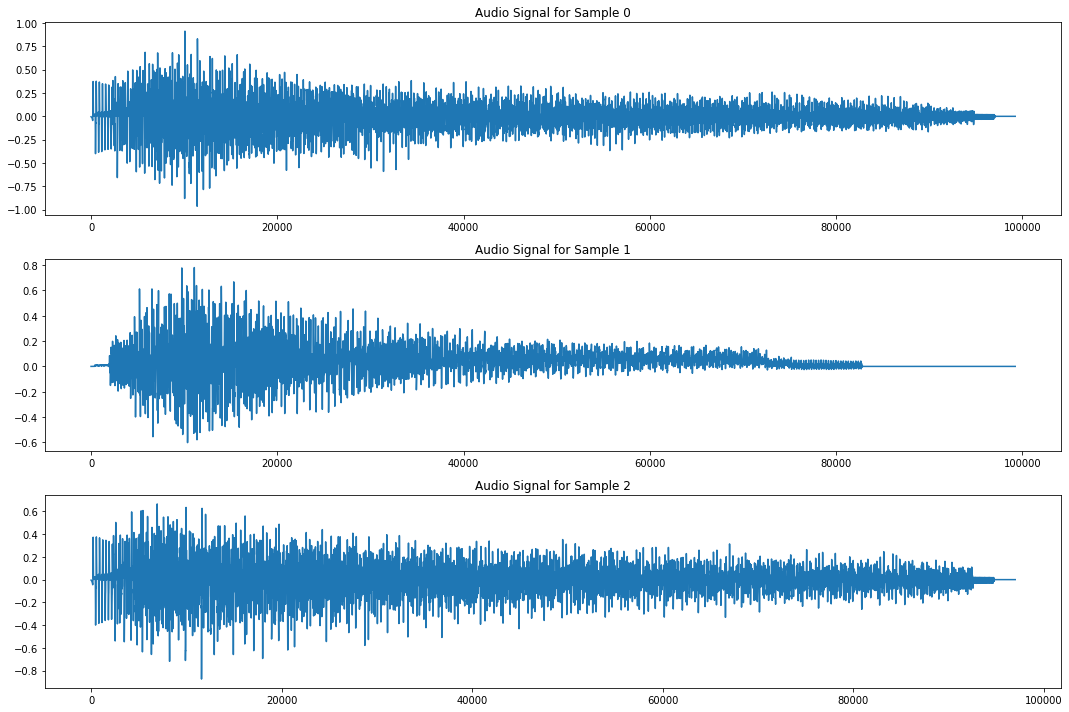

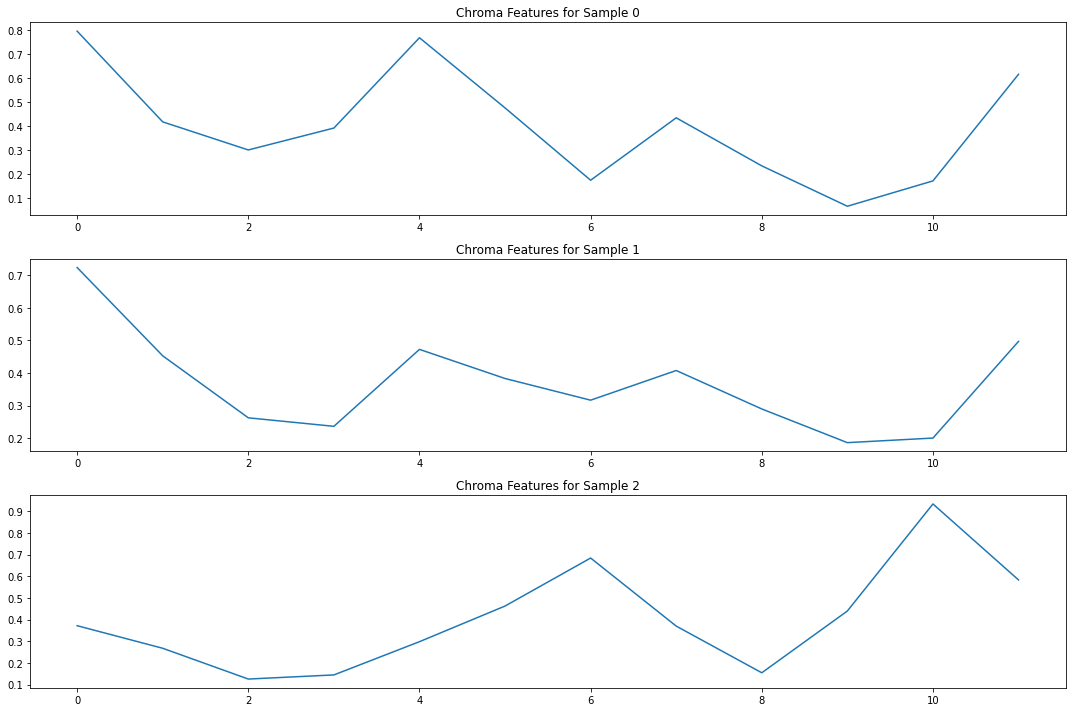

In [26]:
import matplotlib.pyplot as plt

# Plot a few audio signals to verify that they are different
fig, axes = plt.subplots(3, 1, figsize=(15, 10))

for i, ax in enumerate(axes):
    if i < len(augmented_features_df):
        audio_signal = augmented_features_df.loc[i, 'audio_signal']
        ax.plot(audio_signal)
        ax.set_title(f"Audio Signal for Sample {i}")
        
plt.tight_layout()
plt.show()

# Plot a few chroma features to verify variability
fig, axes = plt.subplots(3, 1, figsize=(15, 10))

for i, ax in enumerate(axes):
    if i < len(augmented_features_df):
        chroma = augmented_features_df.loc[i, 'chroma']
        ax.plot(chroma)
        ax.set_title(f"Chroma Features for Sample {i}")

plt.tight_layout()
plt.show()


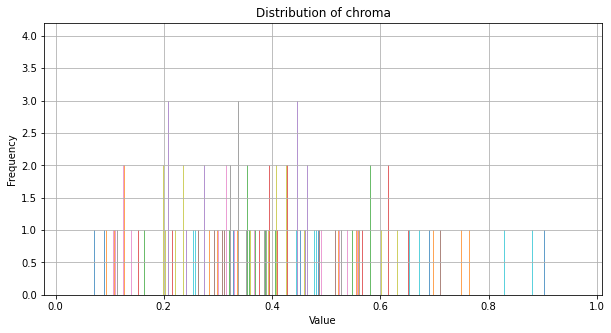

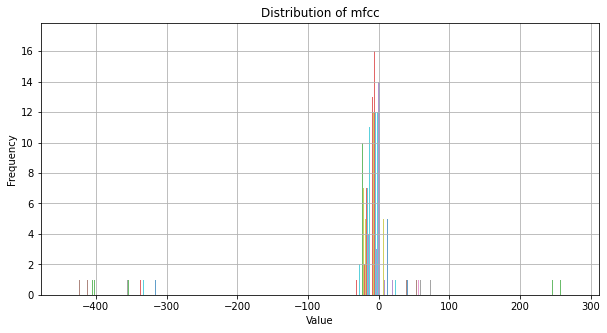

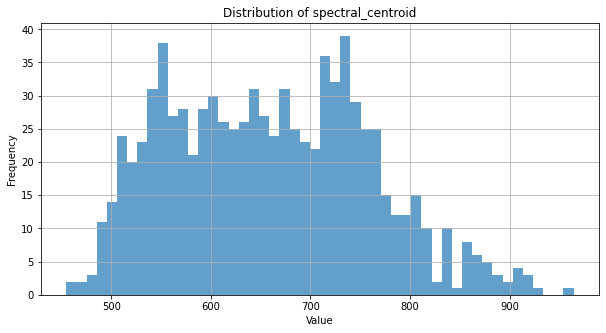

In [27]:
import matplotlib.pyplot as plt

# Plot distributions for key features
def plot_feature_distribution(df, feature_name, num_bins=50):
    if feature_name in df.columns:
        feature_values = df[feature_name].dropna()
        if isinstance(feature_values.iloc[0], list):
            # Flatten list features before plotting
            feature_values = feature_values.apply(pd.Series).stack()
        
        plt.figure(figsize=(10, 5))
        plt.hist(feature_values, bins=num_bins, alpha=0.7)
        plt.title(f'Distribution of {feature_name}')
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.show()
        
plot_feature_distribution(augmented_features_df, 'chroma')
plot_feature_distribution(augmented_features_df, 'mfcc')
plot_feature_distribution(augmented_features_df, 'spectral_centroid')


In [28]:
# Calculate variance or standard deviation of features that should vary
def calculate_feature_variance(df, feature_name):
    if feature_name in df.columns:
        feature_values = df[feature_name].dropna()

        if isinstance(feature_values.iloc[0], (list, np.ndarray)):
            # Flatten the feature values by converting each list to a Series and stacking them
            flattened_values = feature_values.apply(pd.Series).stack().values
        else:
            flattened_values = feature_values.values

        # Calculate and return the variance of the flattened values
        return np.var(flattened_values)

# Apply the updated function to calculate variance of features
chroma_variance = calculate_feature_variance(augmented_features_df, 'chroma')
mfcc_variance = calculate_feature_variance(augmented_features_df, 'mfcc')
harmonic_variance = calculate_feature_variance(augmented_features_df, 'harmonics')

# Print the results
print(f"Chroma Variance: {chroma_variance}")
print(f"MFCC Variance: {mfcc_variance}")
print(f"Harmonics Variance: {harmonic_variance}")


Chroma Variance: 0.04029037803411484
MFCC Variance: 9392.1591796875
Harmonics Variance: 863439.6652240002


---

## Feature Engineering

### Revised Steps for Feature Extraction and Analysis

    Convert Lists to Separate Columns: Since each feature (e.g., harmonics, intervals) is now a list, we'll need to split these lists into separate columns, similar to your original format. We'll achieve this by expanding these lists/arrays into individual columns.

    Perform Feature Analysis: Once we split the features, we can carry out the same analysis, such as variance filtering, KDE plotting, correlation analysis, etc.

In [29]:
def expand_features(df, features_to_expand):
    expanded_df = df.copy()
    for feature in features_to_expand:
        if feature in df.columns:
            # Expand each list/array into separate columns with appropriate prefix
            expanded_features = pd.DataFrame(df[feature].tolist(), index=df.index)
            expanded_features.columns = [f'{feature}_{i+1}' for i in range(expanded_features.shape[1])]
            # Add the expanded columns to the original dataframe and drop the original
            expanded_df = pd.concat([expanded_df, expanded_features], axis=1).drop(columns=[feature])
    return expanded_df

# Expand harmonics and intervals in the raw data
features_to_expand = ['harmonics', 'intervals']
expanded_raw_features_df = expand_features(raw_features_df, features_to_expand)

print("Available Columns in Expanded DataFrame:")
print(expanded_raw_features_df.columns)


Available Columns in Expanded DataFrame:
Index(['id', 'Label', 'audio_signal', 'chroma', 'mfcc', 'spectral_centroid',
       'zero_crossing_rate', 'mel_spectrogram', 'harmonics_1', 'harmonics_2',
       'harmonics_3', 'harmonics_4', 'harmonics_5', 'harmonics_6',
       'harmonics_7', 'harmonics_8', 'harmonics_9', 'harmonics_10',
       'harmonics_11', 'harmonics_12', 'harmonics_13', 'harmonics_14',
       'harmonics_15', 'harmonics_16', 'harmonics_17', 'harmonics_18',
       'harmonics_19', 'harmonics_20', 'harmonics_21', 'intervals_1',
       'intervals_2', 'intervals_3', 'intervals_4', 'intervals_5',
       'intervals_6', 'intervals_7', 'intervals_8', 'intervals_9',
       'intervals_10', 'intervals_11', 'intervals_12', 'intervals_13',
       'intervals_14', 'intervals_15', 'intervals_16', 'intervals_17',
       'intervals_18', 'intervals_19', 'intervals_20'],
      dtype='object')


In [30]:
# Filter Harmonic and Interval Columns for Analysis
harmonic_columns = [col for col in expanded_raw_features_df.columns if 'harmonics_' in col]
interval_columns = [col for col in expanded_raw_features_df.columns if 'intervals_' in col]

# Filter out columns with zero variance
harmonic_columns_with_variance = [col for col in harmonic_columns if expanded_raw_features_df[col].var() > 0]
interval_columns_with_variance = [col for col in interval_columns if expanded_raw_features_df[col].var() > 0]


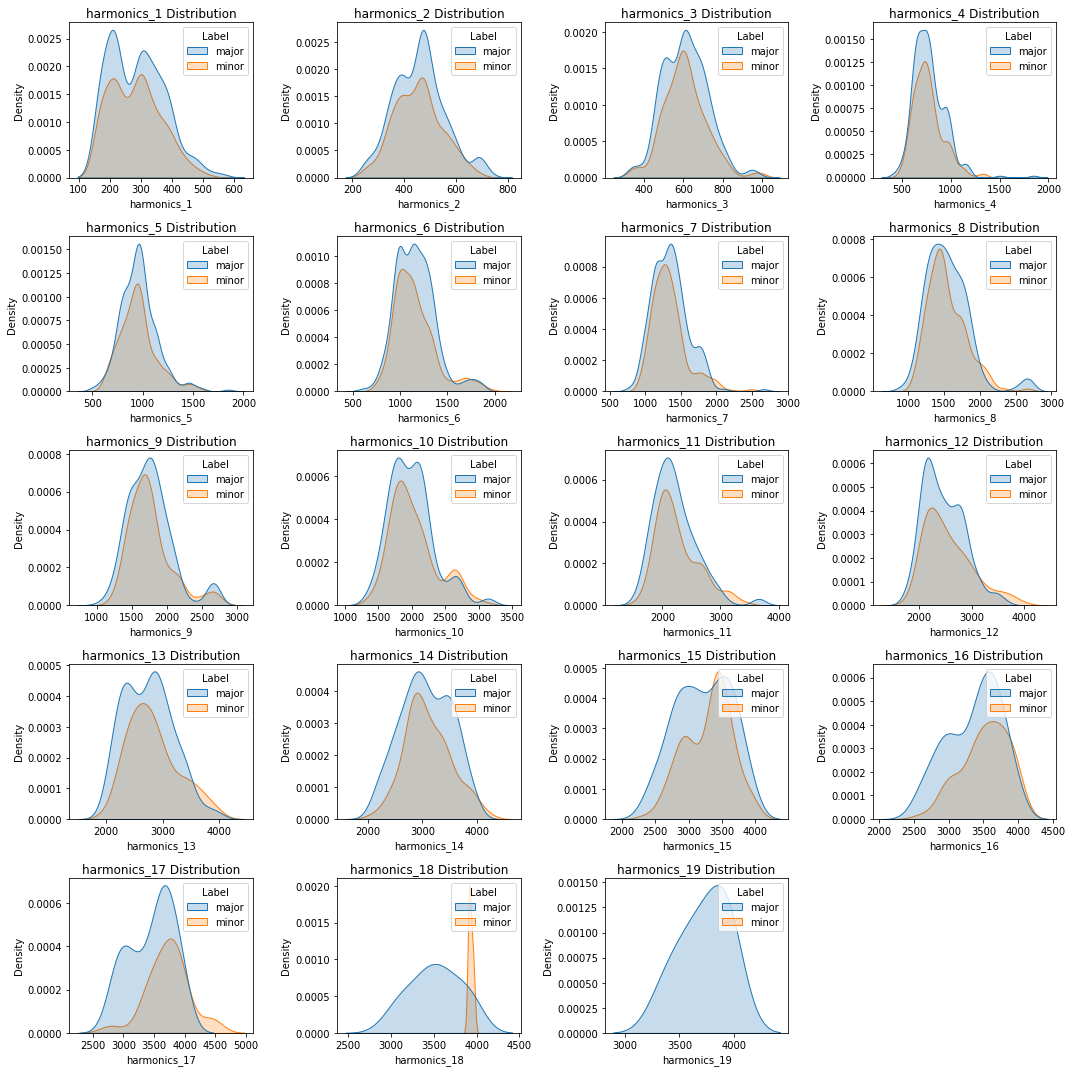

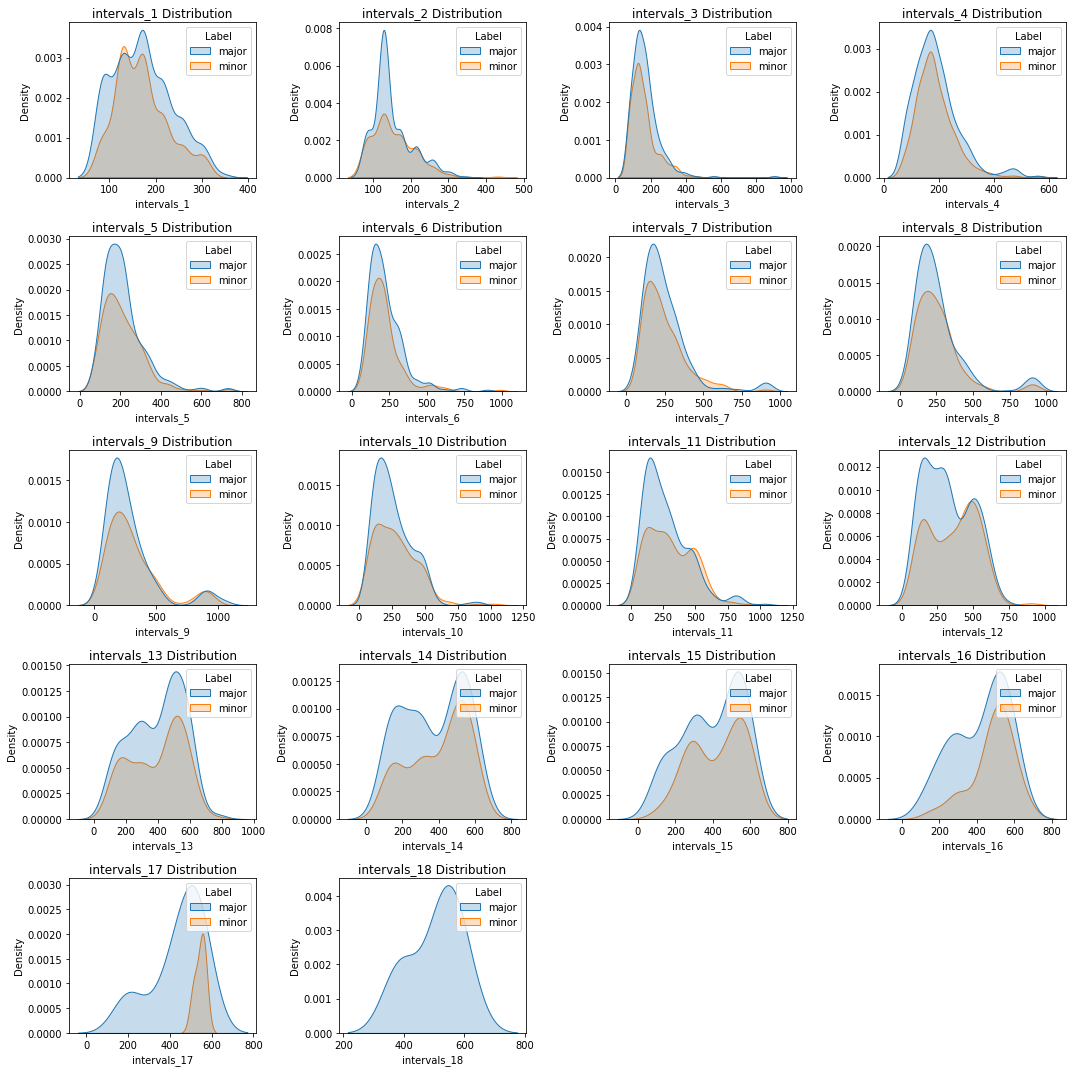

In [31]:
# Function to plot features
def plot_feature_distributions(feature_columns, title, df):
    num_cols = 4
    num_rows = int(np.ceil(len(feature_columns) / num_cols))
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3))
    axes = axes.flatten()  # Flatten axes for easier iteration

    for i, col in enumerate(feature_columns):
        sns.kdeplot(ax=axes[i], data=df, x=col, hue="Label", fill=True)
        axes[i].set_title(f'{col} Distribution')

    # Hide extra subplots if necessary
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.tight_layout()
    plt.show()

# Plot Harmonics and Intervals
plot_feature_distributions(harmonic_columns_with_variance, "Harmonics Distribution", expanded_raw_features_df)
plot_feature_distributions(interval_columns_with_variance, "Intervals Distribution", expanded_raw_features_df)


In [32]:
# Combine harmonics and intervals for correlation analysis
valid_columns = harmonic_columns_with_variance + interval_columns_with_variance

# Fill NaN values with the column mean for the numeric columns only
expanded_raw_features_df_clean = expanded_raw_features_df.copy()
expanded_raw_features_df_clean[valid_columns] = expanded_raw_features_df_clean[valid_columns].fillna(
    expanded_raw_features_df[valid_columns].mean()
)

# Correlation Analysis
if not expanded_raw_features_df_clean.empty:
    correlations = expanded_raw_features_df_clean[valid_columns].corrwith(
        expanded_raw_features_df_clean['Label'].astype('category').cat.codes
    )

    # Sort the correlations by absolute value
    sorted_correlations = correlations.abs().sort_values(ascending=False)
    print("Top 10 Important Features based on Correlation:\n", sorted_correlations.head(10))


Top 10 Important Features based on Correlation:
 harmonics_17    0.094177
harmonics_16    0.085390
harmonics_12    0.077911
intervals_12    0.074233
harmonics_13    0.062932
intervals_16    0.059228
intervals_11    0.059111
intervals_3     0.054789
harmonics_18    0.053006
harmonics_15    0.050319
dtype: float64


#### Ratios Between Specific Harmonics

While harmonic frequencies and intervals between them are useful, the way they relate to major vs minor chords could be more nuanced than just the interval values (like we are using). Major and minor chords differ mainly in the 3rd interval (major third vs minor third). We will focus on specific intervals or harmonic relationships that are known to differentiate major and minor chords.

We will compute the ratio between the 1st harmonic and the 3rd harmonic for each chord - and use that as a new feature. 

In [33]:
# Copy the raw features dataframe
features_df = raw_features_df.copy()

# Standardized Function to Extract Harmonic Ratios
def extract_harmonic_ratios_standardized(df):
    harmonic_ratios = []
    for idx, row in df.iterrows():
        ratios = {}
        harmonics = row['harmonics']

        # Ensure harmonics is a list or array and contains more than one value
        if isinstance(harmonics, (list, np.ndarray)) and len(harmonics) > 1:
            # Use itertools.combinations to get all pairs (i, j) with i < j
            for i, j in itertools.combinations(range(len(harmonics)), 2):
                # Always use the lower index as the denominator to ensure consistency
                if harmonics[i] > 1e-6:  # Avoid division by zero or near-zero values
                    ratio_key = f'ratio_{i+1}_to_{j+1}'  # Naming convention: low index to high index
                    ratios[ratio_key] = harmonics[j] / harmonics[i]
                else:
                    ratios[ratio_key] = np.nan

        harmonic_ratios.append(ratios)
    
    # Convert harmonic ratios to DataFrame and ensure proper numeric type
    harmonic_ratios_df = pd.DataFrame(harmonic_ratios).apply(pd.to_numeric, errors='coerce')
    
    # Extract only the id and Label columns from the original dataframe
    id_label_df = df[['id', 'Label']].reset_index(drop=True)
    
    # Concatenate id, Label, and harmonic ratios into a new DataFrame
    ratios_df = pd.concat([id_label_df, harmonic_ratios_df.reset_index(drop=True)], axis=1)
    
    return ratios_df

# Apply the function to expand selected harmonic ratios (for evaluation)
features_with_ratios_df = extract_harmonic_ratios_standardized(features_df)

# Replace NaN values with 0 for simplicity in evaluation
features_with_ratios_df.fillna(0, inplace=True)

# Display a few rows for validation
print("Features DataFrame with Harmonic Ratios:")
print(features_with_ratios_df.head())

Features DataFrame with Harmonic Ratios:
          id  Label  ratio_1_to_2  ratio_1_to_3  ratio_1_to_4  ratio_1_to_5  \
0    Major_0  major      1.500000      2.000000      2.500000      3.000000   
1    Major_1  major      1.333333      1.666667      2.000000      2.555556   
2   Major_10  major      1.500000      2.000000      2.833333      3.666667   
3  Major_100  major      1.285714      2.000000      2.571429      3.142857   
4  Major_101  major      1.285714      2.285714      3.142857      3.714286   

   ratio_1_to_6  ratio_1_to_7  ratio_1_to_8  ratio_1_to_9  ...  \
0      4.000000      4.500000      5.166667      6.166667  ...   
1      3.000000      3.444444      5.111111      0.000000  ...   
2      4.333333      5.166667      5.500000      7.166667  ...   
3      3.714286      4.571429      5.142857      5.571429  ...   
4      4.142857      5.142857      0.000000      0.000000  ...   

   ratio_15_to_21  ratio_16_to_20  ratio_16_to_21  ratio_17_to_20  \
0             0.0 

In [34]:
# Display some example values in the ratio columns
ratio_columns = [col for col in features_with_ratios_df.columns if 'ratio_' in col]

# Show a few rows for some ratio columns to understand the data type and structure
for col in ratio_columns[:5]:  # Limiting to 5 columns to avoid excessive output
    print(f"Sample values from '{col}':")
    print(features_with_ratios_df[col].head(10))
    print("-" * 50)


Sample values from 'ratio_1_to_2':
0    1.500000
1    1.333333
2    1.500000
3    1.285714
4    1.285714
5    1.285714
6    1.285714
7    1.285714
8    1.285714
9    2.000000
Name: ratio_1_to_2, dtype: float64
--------------------------------------------------
Sample values from 'ratio_1_to_3':
0    2.000000
1    1.666667
2    2.000000
3    2.000000
4    2.285714
5    2.000000
6    2.285714
7    2.000000
8    2.000000
9    2.571429
Name: ratio_1_to_3, dtype: float64
--------------------------------------------------
Sample values from 'ratio_1_to_4':
0    2.500000
1    2.000000
2    2.833333
3    2.571429
4    3.142857
5    2.571429
6    3.285714
7    2.571429
8    2.285714
9    3.142857
Name: ratio_1_to_4, dtype: float64
--------------------------------------------------
Sample values from 'ratio_1_to_5':
0    3.000000
1    2.555556
2    3.666667
3    3.142857
4    3.714286
5    3.285714
6    3.714286
7    3.142857
8    3.142857
9    3.714286
Name: ratio_1_to_5, dtype: float64
-------

In [35]:
# Filter Harmonic Ratios Based on Variance
def filter_low_variance_ratios(df, threshold=0.01):
    ratio_columns = [col for col in df.columns if 'ratio_' in col]
    selected_columns = []

    # Loop over each ratio column to calculate variance and filter
    for col in ratio_columns:
        variance = df[col].var()
        if variance > threshold:
            selected_columns.append(col)

    return selected_columns

# Select harmonic ratio columns with sufficient variance
selected_harmonic_ratios = filter_low_variance_ratios(features_with_ratios_df)

# Print the selected ratios
if selected_harmonic_ratios:
    print(f"\nTop Harmonic Ratios Selected: {selected_harmonic_ratios}")
else:
    print("\nNo harmonic ratios were selected after filtering by variance.")



Top Harmonic Ratios Selected: ['ratio_1_to_2', 'ratio_1_to_3', 'ratio_1_to_4', 'ratio_1_to_5', 'ratio_1_to_6', 'ratio_1_to_7', 'ratio_1_to_8', 'ratio_1_to_9', 'ratio_1_to_10', 'ratio_1_to_11', 'ratio_1_to_12', 'ratio_1_to_13', 'ratio_1_to_14', 'ratio_1_to_15', 'ratio_2_to_3', 'ratio_2_to_4', 'ratio_2_to_5', 'ratio_2_to_6', 'ratio_2_to_7', 'ratio_2_to_8', 'ratio_2_to_9', 'ratio_2_to_10', 'ratio_2_to_11', 'ratio_2_to_12', 'ratio_2_to_13', 'ratio_2_to_14', 'ratio_2_to_15', 'ratio_3_to_4', 'ratio_3_to_5', 'ratio_3_to_6', 'ratio_3_to_7', 'ratio_3_to_8', 'ratio_3_to_9', 'ratio_3_to_10', 'ratio_3_to_11', 'ratio_3_to_12', 'ratio_3_to_13', 'ratio_3_to_14', 'ratio_3_to_15', 'ratio_4_to_5', 'ratio_4_to_6', 'ratio_4_to_7', 'ratio_4_to_8', 'ratio_4_to_9', 'ratio_4_to_10', 'ratio_4_to_11', 'ratio_4_to_12', 'ratio_4_to_13', 'ratio_4_to_14', 'ratio_4_to_15', 'ratio_5_to_6', 'ratio_5_to_7', 'ratio_5_to_8', 'ratio_5_to_9', 'ratio_5_to_10', 'ratio_5_to_11', 'ratio_5_to_12', 'ratio_5_to_13', 'ratio_5_to_

In [36]:
# Statistical Evaluation for Harmonic Ratios with Enhanced Robustness
def evaluate_harmonic_ratios(df, selected_ratios, label_column='Label', p_value_threshold=0.05, epsilon=1e-6, apply_correction=False):
    ratios_stats = []
    for ratio in selected_ratios:
        if ratio in df.columns:
            major_values = df[df[label_column] == 'Major'][ratio].dropna()
            minor_values = df[df[label_column] == 'Minor'][ratio].dropna()

            # Perform t-test and calculate Cohen's d if both groups are non-empty
            if len(major_values) > 1 and len(minor_values) > 1:
                # Perform t-test using scipy.stats
                t_stat, p_value = stats.ttest_ind(major_values, minor_values, equal_var=False)
                
                # Calculate Cohen's d with epsilon for numerical stability
                pooled_var = (major_values.var(ddof=1) + minor_values.var(ddof=1)) / 2
                cohens_d = (major_values.mean() - minor_values.mean()) / np.sqrt(pooled_var + epsilon)
                
                # Append the stats
                ratios_stats.append({'ratio': ratio, 'p_value': p_value, 'cohens_d': cohens_d})

    # Apply Multiple Comparisons Correction if needed
    if apply_correction and ratios_stats:
        p_values = [r_stat['p_value'] for r_stat in ratios_stats]
        # Apply Benjamini-Hochberg correction
        reject, corrected_p_values, _, _ = multipletests(p_values, alpha=p_value_threshold, method='fdr_bh')
        
        # Update the ratios_stats with corrected p-values and significance
        for i, r_stat in enumerate(ratios_stats):
            r_stat['corrected_p_value'] = corrected_p_values[i]
            r_stat['significant'] = reject[i]
        # Sort by corrected p-value ascending
        ratios_stats = sorted(ratios_stats, key=lambda x: x['corrected_p_value'])
    else:
        # Sort by p-value ascending without correction
        ratios_stats = sorted(ratios_stats, key=lambda x: x['p_value'])
    
    return ratios_stats

# Apply the Evaluation Function to the Expanded DataFrame
ratios_stats = evaluate_harmonic_ratios(features_with_ratios_df, selected_harmonic_ratios, apply_correction=False)

# Display the Evaluated Ratios, Ranked by p-value
print("\nRanked Evaluated Harmonic Ratios (without Multiple Comparisons Correction):")
for stats_dict in ratios_stats:
    print(f"{stats_dict['ratio']}: p-value = {stats_dict['p_value']:.4f}, Cohen's d = {stats_dict['cohens_d']:.4f}")



Ranked Evaluated Harmonic Ratios (without Multiple Comparisons Correction):


In [37]:
p_values = [stat['p_value'] for stat in ratios_stats]
cohens_d_values = [abs(stat['cohens_d']) for stat in ratios_stats]

# Print some summary statistics
print("\nSummary Statistics for p-values and Cohen's d:")
print(f"Number of p-values < 0.05: {sum(p < 0.05 for p in p_values)}")
print(f"Number of p-values < 0.01: {sum(p < 0.01 for p in p_values)}")
print(f"Number of Cohen's d > 0.15: {sum(d > 0.15 for d in cohens_d_values)}")
print(f"Number of Cohen's d > 0.10: {sum(d > 0.10 for d in cohens_d_values)}")



Summary Statistics for p-values and Cohen's d:
Number of p-values < 0.05: 0
Number of p-values < 0.01: 0
Number of Cohen's d > 0.15: 0
Number of Cohen's d > 0.10: 0


In [38]:
# Extract and Save Significant Ratios with More Relaxed Criteria
significant_ratios = [stats_dict['ratio'] for stats_dict in ratios_stats if stats_dict['p_value'] < 0.05 and abs(stats_dict['cohens_d']) > 0.1]
print(f"\nSignificant Harmonic Ratios (p-value < 0.05 and |Cohen's d| > 0.1): {significant_ratios}")


Significant Harmonic Ratios (p-value < 0.05 and |Cohen's d| > 0.1): []


---

In [39]:
# Visually Identified Ratios
visually_identified_ratios = [
    'ratio_1_to_4', 'ratio_1_to_9', 'ratio_2_to_3', 'ratio_3_to_1',
    'ratio_3_to_12', 'ratio_5_to_10', 'ratio_5_to_12', 'ratio_5_to_13',
    'ratio_5_to_15', 'ratio_5_to_16', 'ratio_5_to_9', 'ratio_6_to_15',
    'ratio_7_to_9', 'ratio_7_to_13', 'ratio_7_to_15', 'ratio_10_to_12',
    'ratio_10_to_13', 'ratio_10_to_14', 'ratio_10_to_15', 'ratio_18_to_1'
]

# Common Ratios Between Visually Identified and Statistically Selected
common_ratios = list(set(visually_identified_ratios) & set(selected_harmonic_ratios))

# Save the results to lists
num_visually_identified_ratios = len(visually_identified_ratios)
num_statistically_selected_ratios = len(selected_harmonic_ratios)
num_common_ratios = len(common_ratios)

# Print the results and save to variables
print(f"\nNumber of Ratios Previously Identified Visually: {num_visually_identified_ratios}")
print(f"Visually Identified Ratios: {visually_identified_ratios}")

print(f"\nNumber of Ratios Selected via Statistical Evaluation: {num_statistically_selected_ratios}")
# print(f"Statistically Selected Ratios: {selected_harmonic_ratios}")

print(f"\nNumber of Common Ratios: {num_common_ratios}")
print(f"Common Ratios: {common_ratios}")

# Lists to refer later
list_visually_identified_ratios = visually_identified_ratios
list_statistically_selected_ratios = selected_harmonic_ratios
list_common_ratios = common_ratios



Number of Ratios Previously Identified Visually: 20
Visually Identified Ratios: ['ratio_1_to_4', 'ratio_1_to_9', 'ratio_2_to_3', 'ratio_3_to_1', 'ratio_3_to_12', 'ratio_5_to_10', 'ratio_5_to_12', 'ratio_5_to_13', 'ratio_5_to_15', 'ratio_5_to_16', 'ratio_5_to_9', 'ratio_6_to_15', 'ratio_7_to_9', 'ratio_7_to_13', 'ratio_7_to_15', 'ratio_10_to_12', 'ratio_10_to_13', 'ratio_10_to_14', 'ratio_10_to_15', 'ratio_18_to_1']

Number of Ratios Selected via Statistical Evaluation: 188

Number of Common Ratios: 18
Common Ratios: ['ratio_5_to_9', 'ratio_5_to_15', 'ratio_10_to_15', 'ratio_10_to_13', 'ratio_5_to_12', 'ratio_2_to_3', 'ratio_7_to_15', 'ratio_1_to_9', 'ratio_7_to_13', 'ratio_10_to_12', 'ratio_5_to_13', 'ratio_5_to_10', 'ratio_10_to_14', 'ratio_7_to_9', 'ratio_5_to_16', 'ratio_3_to_12', 'ratio_6_to_15', 'ratio_1_to_4']


In [40]:
selected_features = [
    # Harmonics Based on Correlation
#     'harmonics_17', 'harmonics_16', 'harmonics_12', 'harmonics_13',
#     'harmonics_18', 'harmonics_15',

    # Intervals Based on Correlation
#     'intervals_12', 'intervals_16', 'intervals_11', 'intervals_3',

    # Harmonic Ratios Based on Statistical Evaluation
    'ratio_5_to_12', 'ratio_5_to_10', 'ratio_10_to_14', 'ratio_10_to_12', 
    'ratio_5_to_15', 'ratio_7_to_13', 'ratio_7_to_15', 'ratio_10_to_13', 
    'ratio_1_to_9', 'ratio_5_to_16', 'ratio_10_to_15', 'ratio_1_to_4', 
    'ratio_5_to_9', 'ratio_7_to_9', 'ratio_2_to_3', 'ratio_3_to_12', 
    'ratio_6_to_15', 'ratio_5_to_13'
]

In [41]:
filtered_raw_ratios_df = features_with_ratios_df[['id', 'Label'] + selected_features]

filtered_raw_ratios_df.head()

,id,Label,ratio_5_to_12,ratio_5_to_10,ratio_10_to_14,ratio_10_to_12,ratio_5_to_15,ratio_7_to_13,ratio_7_to_15,ratio_10_to_13,ratio_1_to_9,ratio_5_to_16,ratio_10_to_15,ratio_1_to_4,ratio_5_to_9,ratio_7_to_9,ratio_2_to_3,ratio_3_to_12,ratio_6_to_15,ratio_5_to_13
0,Major_0,major,3.000000,2.555556,1.586957,1.173913,4.722222,2.259259,3.148148,1.326087,6.166667,0.0,1.847826,2.500000,2.055556,1.370370,1.333333,4.500000,3.541667,3.388889
1,Major_1,major,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,2.000000,0.000000,0.000000,1.250000,0.000000,0.000000,0.000000
2,Major_10,major,2.772727,2.090909,0.000000,1.326087,0.000000,2.096774,0.000000,1.413043,7.166667,0.0,0.000000,2.833333,1.954545,1.387097,1.333333,5.083333,0.000000,2.954545
3,Major_100,major,2.318182,1.954545,1.813953,1.186047,4.136364,2.031250,2.843750,1.511628,5.571429,0.0,2.116279,2.571429,1.772727,1.218750,1.555556,3.642857,3.500000,2.954545
4,Major_101,major,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,3.142857,0.000000,0.000000,1.777778,0.000000,0.000000,0.000000


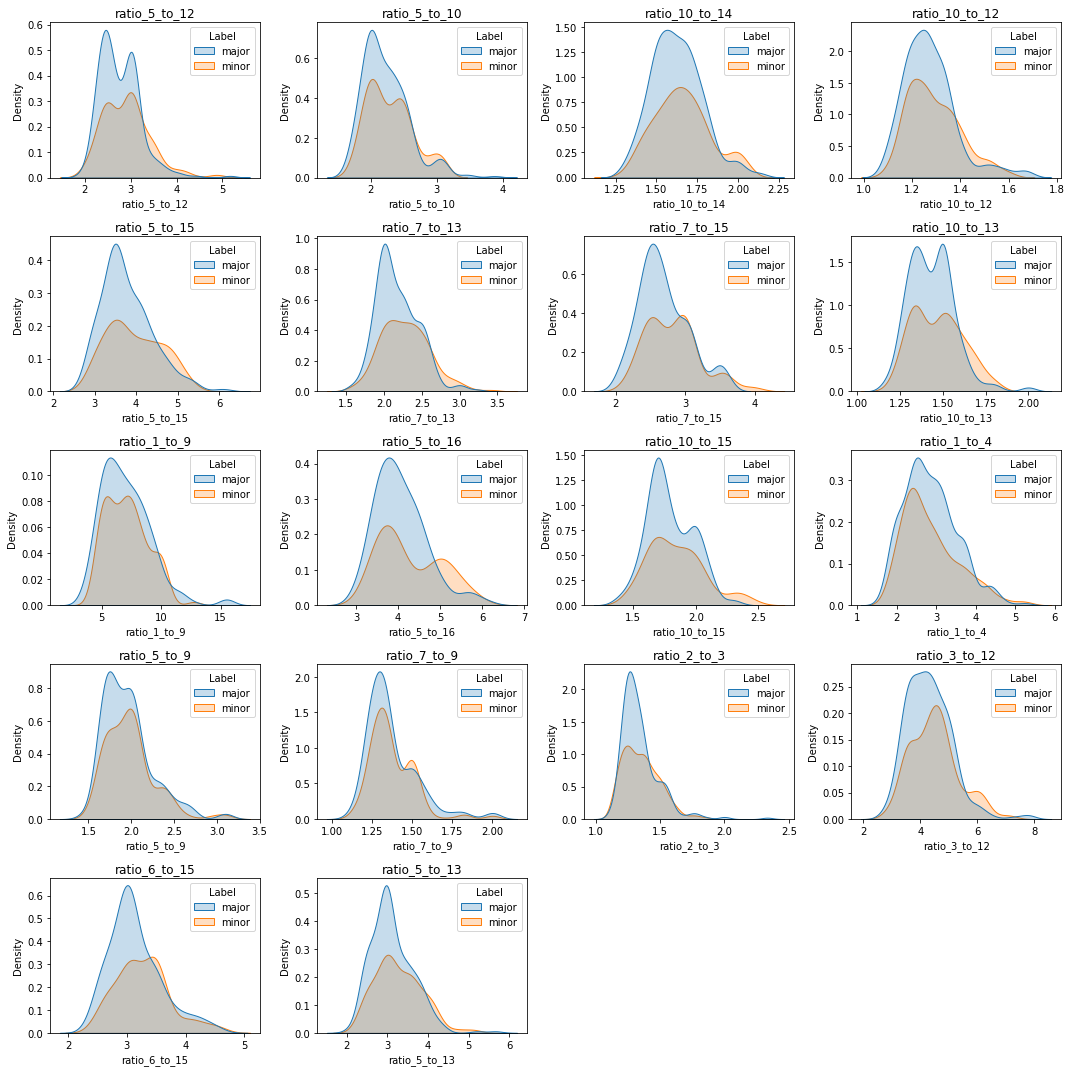

In [42]:
# Plot Selected Harmonic Ratios for Filtered DataFrame
def plot_selected_harmonic_ratios_non_zero(df, selected_ratios):
    num_cols = 4
    num_rows = int(np.ceil(len(selected_ratios) / num_cols))

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3))
    axes = axes.flatten()

    for i, ratio in enumerate(selected_ratios):
        if ratio in df.columns:
            filtered_data = df[df[ratio] != 0]  # Remove zero values for plotting
            if len(filtered_data) > 10:  # Ensure enough data points remain for plotting
                sns.kdeplot(ax=axes[i], data=filtered_data, x=ratio, hue="Label", fill=True)
                axes[i].set_title(ratio)
            else:
                axes[i].set_visible(False)

    # Hide extra subplots if there are any
    for j in range(len(selected_ratios), len(axes)):
        fig.delaxes(axes[j])

    fig.tight_layout()
    plt.show()

# Plot selected harmonic ratios for filtered_raw_ratios_df
plot_selected_harmonic_ratios_non_zero(filtered_raw_ratios_df, selected_features)


In [43]:
# Check which selected features are present or missing from the filtered_raw_ratios_df
missing_features = [feature for feature in selected_features if feature not in filtered_raw_ratios_df.columns]
available_features = [feature for feature in selected_features if feature in filtered_raw_ratios_df.columns]

print("\nMissing Features from Filtered Raw Ratios DataFrame:")
print(missing_features)

print("\nAvailable Features in Filtered Raw Ratios DataFrame:")
print(available_features)


Missing Features from Filtered Raw Ratios DataFrame:
[]

Available Features in Filtered Raw Ratios DataFrame:
['ratio_5_to_12', 'ratio_5_to_10', 'ratio_10_to_14', 'ratio_10_to_12', 'ratio_5_to_15', 'ratio_7_to_13', 'ratio_7_to_15', 'ratio_10_to_13', 'ratio_1_to_9', 'ratio_5_to_16', 'ratio_10_to_15', 'ratio_1_to_4', 'ratio_5_to_9', 'ratio_7_to_9', 'ratio_2_to_3', 'ratio_3_to_12', 'ratio_6_to_15', 'ratio_5_to_13']


---
#### for augmented data:

In [44]:
# Expand Harmonic Ratios Between All Pairs for Evaluation (For Augmented Data)
def extract_harmonic_ratios_augmented(df):
    harmonic_ratios = []
    for idx, row in df.iterrows():
        ratios = {}
        harmonics = row['harmonics']

        # Ensure harmonics is a list or array and contains more than one value
        if isinstance(harmonics, (list, np.ndarray)) and len(harmonics) > 1:
            # Filter out zero or near-zero harmonics to avoid invalid ratios
            harmonics = [h for h in harmonics if h > 1e-6]
            if len(harmonics) > 1:
                # Calculate ratios between all possible harmonic pairs
                for i, j in itertools.combinations(range(len(harmonics)), 2):
                    ratio_key = f'ratio_{i+1}_to_{j+1}'
                    if harmonics[i] != 0:  # Avoid division by zero
                        ratios[ratio_key] = harmonics[j] / harmonics[i]
                    else:
                        ratios[ratio_key] = np.nan

        harmonic_ratios.append(ratios)
    
    # Convert harmonic ratios to DataFrame and ensure proper numeric type
    harmonic_ratios_df = pd.DataFrame(harmonic_ratios).apply(pd.to_numeric, errors='coerce')
    
    # Extract only the id and Label columns from the original dataframe
    id_label_df = df[['id', 'Label']].copy().reset_index(drop=True)
    
    # Concatenate id, Label, and harmonic ratios into a new DataFrame
    augmented_ratios_df = pd.concat([id_label_df, harmonic_ratios_df.reset_index(drop=True)], axis=1)
    
    return augmented_ratios_df

# Apply the Function to Extract Harmonic Ratios (for augmented data)
augmented_ratios_df = extract_harmonic_ratios_augmented(augmented_features_df)

# Replace NaN values with 0 for simplicity in evaluation
augmented_ratios_df.fillna(0, inplace=True)

# Displaying a few rows for validation
print("\nSample of Augmented Ratios DataFrame:")
print(augmented_ratios_df.head())


Sample of Augmented Ratios DataFrame:
          id  Label  ratio_1_to_2  ratio_1_to_3  ratio_1_to_4  ratio_1_to_5  \
0    Major_0  major      1.500000      2.000000      2.500000      3.000000   
1    Major_1  major      1.333333      1.666667      2.000000      2.555556   
2   Major_10  major      1.500000      2.000000      2.833333      3.666667   
3  Major_100  major      1.285714      2.000000      2.571429      3.142857   
4  Major_101  major      1.285714      2.285714      3.142857      3.714286   

   ratio_1_to_6  ratio_1_to_7  ratio_1_to_8  ratio_1_to_9  ...  \
0      4.000000      4.500000      5.166667      6.166667  ...   
1      3.000000      3.444444      5.111111      0.000000  ...   
2      4.333333      5.166667      5.500000      7.166667  ...   
3      3.714286      4.571429      5.142857      5.571429  ...   
4      4.142857      5.142857      0.000000      0.000000  ...   

   ratio_15_to_21  ratio_16_to_20  ratio_16_to_21  ratio_17_to_20  \
0             0.0   

In [45]:
filtered_augmented_ratios_df = augmented_ratios_df[['id', 'Label'] + selected_features]

filtered_augmented_ratios_df.head()

,id,Label,ratio_5_to_12,ratio_5_to_10,ratio_10_to_14,ratio_10_to_12,ratio_5_to_15,ratio_7_to_13,ratio_7_to_15,ratio_10_to_13,ratio_1_to_9,ratio_5_to_16,ratio_10_to_15,ratio_1_to_4,ratio_5_to_9,ratio_7_to_9,ratio_2_to_3,ratio_3_to_12,ratio_6_to_15,ratio_5_to_13
0,Major_0,major,3.000000,2.555556,1.586957,1.173913,4.722222,2.259259,3.148148,1.326087,6.166667,0.0,1.847826,2.500000,2.055556,1.370370,1.333333,4.500000,3.541667,3.388889
1,Major_1,major,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,2.000000,0.000000,0.000000,1.250000,0.000000,0.000000,0.000000
2,Major_10,major,2.772727,2.090909,0.000000,1.326087,0.000000,2.096774,0.000000,1.413043,7.166667,0.0,0.000000,2.833333,1.954545,1.387097,1.333333,5.083333,0.000000,2.954545
3,Major_100,major,2.318182,1.954545,1.813953,1.186047,4.136364,2.031250,2.843750,1.511628,5.571429,0.0,2.116279,2.571429,1.772727,1.218750,1.555556,3.642857,3.500000,2.954545
4,Major_101,major,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,3.142857,0.000000,0.000000,1.777778,0.000000,0.000000,0.000000


---

## Finalizing Data before Modeling

- feature toggling because I can't pick favorites

In [46]:
# Verify columns to avoid headaches later yeesh

# Display the columns of raw_complete_df
print("Columns in raw_features_df:")
for col in raw_features_df.columns:
    print(col)

# Separator for better readability
print("\n" + "="*50 + "\n")

# Display the columns of augmented_complete_df
print("Columns in augmented_features_df:")
for col in augmented_features_df.columns:
    print(col)


Columns in raw_features_df:
id
Label
audio_signal
chroma
mfcc
spectral_centroid
zero_crossing_rate
harmonics
intervals
mel_spectrogram


Columns in augmented_features_df:
id
Label
audio_signal
chroma
mfcc
spectral_centroid
zero_crossing_rate
harmonics
intervals
mel_spectrogram


In [47]:
# Extract columns from filtered DataFrames, excluding 'id' and 'Label'
raw_columns = set(filtered_raw_ratios_df.columns) - {'id', 'Label'}
augmented_columns = set(filtered_augmented_ratios_df.columns) - {'id', 'Label'}

# Check if the column sets are the same
if raw_columns == augmented_columns:
    print("Validation Successful: The harmonic ratio columns are the same in both raw and augmented DataFrames.")
else:
    missing_in_raw = augmented_columns - raw_columns
    missing_in_augmented = raw_columns - augmented_columns
    if missing_in_raw:
        print(f"Columns present in augmented_ratios_df but missing in raw_ratios_df: {missing_in_raw}")
    if missing_in_augmented:
        print(f"Columns present in raw_ratios_df but missing in augmented_ratios_df: {missing_in_augmented}")

# Print the number of columns for a quick overview
print(f"Number of columns in filtered_raw_ratios_df (excluding 'id' and 'Label'): {len(raw_columns)}")
print(f"Number of columns in filtered_augmented_ratios_df (excluding 'id' and 'Label'): {len(augmented_columns)}")


Validation Successful: The harmonic ratio columns are the same in both raw and augmented DataFrames.
Number of columns in filtered_raw_ratios_df (excluding 'id' and 'Label'): 18
Number of columns in filtered_augmented_ratios_df (excluding 'id' and 'Label'): 18


---

In [48]:
augmented_features_df.head()

,id,Label,audio_signal,chroma,mfcc,spectral_centroid,zero_crossing_rate,harmonics,intervals,mel_spectrogram
0,Major_0,major,"[-0.004333496, -0.0058898926, -0.0048217773, -...","[0.7968521, 0.41725653, 0.2998105, 0.39145, 0....","[-338.3117, 257.16064, 37.91532, -19.911049, 0...",731.644753,0.021721,"[258.1463414634146, 387.2195121951219, 516.292...","[129.0731707317073, 129.0731707317073, 129.073...","[-22.629173, -18.381105, -14.328545, -12.83876..."
1,Major_1,major,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.7232829, 0.45263815, 0.26252756, 0.23647432...","[-404.3833, 179.5291, 68.798615, 6.5934095, -3...",497.091980,0.011334,"[387.2195121951219, 516.2926829268292, 645.365...","[129.0731707317073, 129.07317073170736, 129.07...","[-42.334816, -45.12371, -50.84518, -55.982666,..."
2,Major_10,major,"[-0.004333496, -0.0058898926, -0.0048217773, -...","[0.37183326, 0.2676605, 0.1256456, 0.14466327,...","[-355.2513, 251.06386, 58.341755, -14.42813, -...",608.686444,0.020248,"[258.1463414634146, 387.2195121951219, 516.292...","[129.0731707317073, 129.0731707317073, 215.121...","[-23.402384, -19.154316, -15.101755, -13.61197..."
3,Major_100,major,"[-0.0062561035, -0.008087158, -0.007171631, -0...","[0.39077398, 0.9342459, 0.7632381, 0.55300677,...","[-336.5666, 255.45099, 25.056515, -28.689547, ...",735.732537,0.024483,"[301.1707317073171, 387.2195121951219, 602.341...","[86.04878048780483, 215.12195121951225, 172.09...","[-26.984245, -23.075817, -19.678623, -15.04869..."
4,Major_101,major,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.20732851, 0.4035183, 0.40069222, 0.4611866,...","[-390.57816, 171.94157, 63.36294, 0.86880636, ...",619.950017,0.012351,"[301.1707317073171, 387.2195121951219, 688.390...","[86.04878048780483, 301.1707317073171, 258.146...","[-38.758972, -41.832405, -47.83084, -51.69927,..."


In [49]:
# Feature Toggles (for future reference when including augmented data)
model_toggles = {
    'chroma': False,
    'mfcc': False,
    'spectral_centroid': False,
    'zero_crossing_rate': False,
    'harmonics': False,
    'intervals': False,
    'mel_spectrogram': False,
    'harmonic_ratios': True
}

In [50]:
def filter_model_data(model_toggles, use_augmentation=False):
    # Start with raw features
    model = raw_features_df.copy()

    # Merge with harmonic ratios if toggled on
    if model_toggles['harmonic_ratios']:
        model = model.merge(filtered_raw_ratios_df, on='id', how='left')

    # Handle augmentation, but don't merge with raw yet
    if use_augmentation:
        a_model = augmented_features_df.copy()

        # Merge with harmonic ratios for augmented data if toggled on
        if model_toggles['harmonic_ratios']:
            a_model = a_model.merge(filtered_augmented_ratios_df, on='id', how='left')

    # Drop columns from both model and a_model based on feature toggles
    columns_to_drop = []
    for feature, use_feature in model_toggles.items():
        if not use_feature and feature in model.columns:
            columns_to_drop.append(feature)

    # Always drop the raw audio signal
    if 'audio_signal' in model.columns:
        columns_to_drop.append('audio_signal')

    # Drop the identified columns in both dataframes
    model.drop(columns=columns_to_drop, inplace=True, errors='ignore')

    if use_augmentation:
        a_model.drop(columns=columns_to_drop, inplace=True, errors='ignore')

    # Handle duplicate Label columns
    for df in [model, a_model if use_augmentation else None]:
        if df is not None:
            if 'Label_x' in df.columns and 'Label_y' in df.columns:
                df.drop(columns=['Label_y'], inplace=True)
                df.rename(columns={'Label_x': 'Label'}, inplace=True)
            elif 'Label_x' in df.columns:
                df.rename(columns={'Label_x': 'Label'}, inplace=True)
            elif 'Label_y' in df.columns:
                df.rename(columns={'Label_y': 'Label'}, inplace=True)

    # Return both model and a_model
    if use_augmentation:
        return model, a_model

    return model, None


In [51]:
raw_model_data, augmented_model_data = filter_model_data(model_toggles, use_augmentation=True)

# Display the resulting dataframes for validation
print("\nFiltered Raw Model Data:")
print(raw_model_data.head())

if augmented_model_data is not None:
    print("\nFiltered Augmented Model Data:")
    print(augmented_model_data.head())
    print(f"Shape of Augmented Model Data: {augmented_model_data.shape}")
else:
    print("\nNo augmented data")
    
print(f"Shape of Raw Model Data: {raw_model_data.shape}")


Filtered Raw Model Data:
          id  Label  ratio_5_to_12  ratio_5_to_10  ratio_10_to_14  \
0    Major_0  major       3.000000       2.555556        1.586957   
1    Major_1  major       0.000000       0.000000        0.000000   
2   Major_10  major       2.772727       2.090909        0.000000   
3  Major_100  major       2.318182       1.954545        1.813953   
4  Major_101  major       0.000000       0.000000        0.000000   

   ratio_10_to_12  ratio_5_to_15  ratio_7_to_13  ratio_7_to_15  \
0        1.173913       4.722222       2.259259       3.148148   
1        0.000000       0.000000       0.000000       0.000000   
2        1.326087       0.000000       2.096774       0.000000   
3        1.186047       4.136364       2.031250       2.843750   
4        0.000000       0.000000       0.000000       0.000000   

   ratio_10_to_13  ratio_1_to_9  ratio_5_to_16  ratio_10_to_15  ratio_1_to_4  \
0        1.326087      6.166667            0.0        1.847826      2.500000   
1 

---

### Model Iterations:

#### Model v1:

First, I wanted to to compare the extract_features method I used in my [last project]() (mostly out of curiosity :p)

This included extracting features like:
- **Chroma Features**: calculated using the short-time Fourier transform (STFT) of the audio file. Chroma features capture the essence of the pitch content within each octave group - which is vital for chord identification.
- **MFCCs**: used to capture the timbral aspects of an audio signal. (This is what makes a song or chord 'feel' a certain way!) The first few coefficients especially provide a good representation of the overall spectral shape which is influenced by the harmonic structure of the chord.

These features were fed into a Convolutional Neural Network (CNN):

| Class | Precision | Recall | F1-score | Support |
|-------|-----------|--------|----------|---------|
| Major | 0.53      | 1.00   | 0.70     | 46      |
| Minor | 0.00      | 0.00   | 0.00     | 40      |
| **accuracy** | | | 0.53 | 86 |
| **macro avg** | 0.27 | 0.50 | 0.35 | 86 |
| **weighted avg** | 0.29 | 0.53 | 0.37 | 86 |

This is alarming - our scores for precision, recall, and f1-score for the Minor class are ALL zero. 
This is probably because we are focusing in on timbral aspects of the audio, rather than the individual frequencies of the notes in the chords. But an interesting first model!


#### Model v2:

After implementing a new feature extraction method to (instead) extract harmonics, these are the results of a simple Logistic Regression as a baseline classifier.

Accuracy: 60.47%

Classification Report (Harmonics & Simple Logistic Regression):

|               | precision | recall | f1-score | support |
|---------------|------------|--------|----------|---------|
| **Major**     | 0.63       | 0.81   | 0.71     | 101     |
| **Minor**     | 0.54       | 0.31   | 0.39     | 71      |
| **accuracy**  |            |        | **0.60**     | 172     |
| **macro avg** | 0.58       | 0.56   | 0.55     | 172     |
| **weighted avg** | 0.59    | 0.60   | 0.58     | 172     |

Confusion Matrix:

[[82 19]

 [49 22]]
 
 
  Lets try a more advanced models:
 
 #### Model v3:
 
Support Vector Machine (SVM): 58.14%
              precision    recall  f1-score   support

       Major       0.60      0.83      0.70       101
       Minor       0.48      0.23      0.31        71

    accuracy                           **0.58**       172
   macro avg       0.54      0.53      0.50       172
weighted avg       0.56      0.58      0.54       172

[[84 17]

 [55 16]]

#### Model v4:

Random Forest Accuracy: 69.19%
              precision    recall  f1-score   support

       Major       0.76      0.70      0.73       101
       Minor       0.62      0.68      0.64        71

    accuracy                           **0.69**       172
   macro avg       0.69      0.69      0.69       172
weighted avg       0.70      0.69      0.69       172

[[71 30]

 [23 48]]
 
 
#### Model v5:

Neural Network Accuracy: 62.79%
              precision    recall  f1-score   support

       Major       0.63      0.89      0.74       101
       Minor       0.62      0.25      0.36        71

    accuracy                           **0.63**       172
   macro avg       0.63      0.57      0.55       172
weighted avg       0.63      0.63      0.58       172

Confusion Matrix for Neural Network:

[[90 11]

 [53 18]]
 
#### Model v6:

Now, using feature engineering to only train with features that will be useful for the model!

Random Tree (with feature engineering):
              precision    recall  f1-score   support

       Major       0.82      0.91      0.86        98
       Minor       0.86      0.73      0.79        74

    accuracy                           **0.83**       172
   macro avg       0.84      0.82      0.82       172
weighted avg       0.83      0.83      0.83       172

Confusion Matrix:

[[89  9]

[20 54]]


#### Model v7:

A lot of audio classification will rely on the MFCCS ( explain later lol ), so I also wanted to attempt combining my original model's method of extracting features with the previous model's feature engineering of the harmonics method. 

Classification Report:
              precision    recall  f1-score   support

       Major       0.74      0.92      0.82        98
       Minor       0.84      0.58      0.69        74

    accuracy                           **0.77**       172
   macro avg       0.79      0.75      0.75       172
weighted avg       0.79      0.77      0.76       172

Confusion Matrix:
[[90  8]
 [31 43]]


#### Model v8:

Neural Network for the same group of features. 

Classification Report:
              precision    recall  f1-score   support

       Major       0.71      0.82      0.76        98
       Minor       0.69      0.55      0.62        74

    accuracy                           **0.70**       172
   macro avg       0.70      0.69      0.69       172
weighted avg       0.70      0.70      0.70       172

Confusion Matrix:

[[80 18]

 [33 41]]
 
#### Model v9:

While harmonic frequencies and intervals between them are useful, the way they relate to major vs minor chords could be more nuanced than just the interval values (like we are using). Major and minor chords differ mainly in the 3rd interval (major third vs minor third). We will focus on specific intervals or harmonic relationships that are known to differentiate major and minor chords.

We will compute the ratio between the 1st harmonic and the 3rd harmonic for each chord - and use that as a new feature. 

Classification Report:
              precision    recall  f1-score   support

       Major       0.77      0.81      0.79        97
       Minor       0.74      0.69      0.72        75

    accuracy                           **0.76**       172
   macro avg       0.76      0.75      0.76       172
weighted avg       0.76      0.76      0.76       172

Confusion Matrix:

[[79 18]

 [23 52]]


#### Model v10: CNN + LSTM

We will generate Mel-Spectograms instead of using a regular spectogram (from librosa.stft), because Mel-spectograms more closely match human perception of sound frequencies. 

Classification Report for Optimized Model:
              precision    recall  f1-score   support

       Major       0.58      1.00      0.74       100
       Minor       0.00      0.00      0.00        72

    accuracy                           **0.58**       172
   macro avg       0.29      0.50      0.37       172
weighted avg       0.34      0.58      0.43       172

Confusion Matrix for Optimized Model:
[[100   0]
 [ 72   0]]
 
Very upsetting that the model only votes for major - we've been seeing this a lot in recent attempts. I'm biting the bullet and giving into data augmentation, but audio can be ~~extremely (':~~ annoying to work with.
 
 #### Model v11: even class distribution
 
 I cleaned up the combining of features to make it easier for me to try different models. This was our first successful model using the augmented data: a CNN + LSTM Model like Model v10, but with ((slightly)) better results.
 
Classification Report:
              precision    recall  f1-score   support

       Major       0.54      1.00      0.70       101
       Minor       1.00      0.13      0.23       100

    accuracy                           **0.57**       201
   macro avg       0.77      0.56      0.46       201
weighted avg       0.77      0.57      0.47       201

Confusion Matrix:
[[101   0]
 [ 87  13]]
 
#### Model v12: addressing data leakage (from combining data before splitting into test / train sets)

I restructured ALL of my code for extracting and engineering features. Fingers are so very crossed.

Classification Report:
              precision    recall  f1-score   support

       major       0.98      0.98      0.98       100
       minor       0.97      0.97      0.97        72

    accuracy                           0.98       172
   macro avg       0.98      0.98      0.98       172
weighted avg       0.98      0.98      0.98       172


Confusion Matrix:
[[98  2]
 [ 2 70]]
 
VERY COOL! This model only included the selected harmonic_ratios:

    'ratio_5_to_12', 'ratio_5_to_10', 'ratio_10_to_14', 'ratio_10_to_12', 
    'ratio_5_to_15', 'ratio_7_to_13', 'ratio_7_to_15', 'ratio_10_to_13', 
    'ratio_1_to_9', 'ratio_5_to_16', 'ratio_10_to_15', 'ratio_1_to_4', 
    'ratio_5_to_9', 'ratio_7_to_9', 'ratio_2_to_3', 'ratio_3_to_12', 
    'ratio_6_to_15', 'ratio_5_to_13'


# Modeling

This is a classification problem, with the goal of predicting whether a chord is major or minor. The initial plan is to use a basic model like logistic regression or SVM as a baseline. After extracting features like MFCCs or spectrograms, we will establish the baseline and then experiment with more advanced models like convolutional neural networks (CNNs) to improve accuracy.

### Data Prep before Modeling:

Combining Different Features to tune the modeling, all done in one spot. (please)

**Note:**
To include the augmented data, uncomment the lines related to `augmented_data`, `filtered_augmented_data`, `X_train_augmented`, and `y_train_augmented`.
Then, set `X_train` to `X_train_augmented` and `y_train` to `y_train_augmented` instead of the raw data.
This allows you to easily add the augmented data when needed, avoiding rewriting the entire process.

In [89]:
# First, make sure the original split is correct
X = raw_model_data.drop(columns=['Label', 'id'])
y = raw_model_data['Label']

# Ensure y is correctly encoded
le = LabelEncoder()
y = le.fit_transform(y)  # Ensure labels are encoded correctly here

# Stratified split to maintain balanced classes
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Now print out the lengths to ensure they match before augmentation
print(f"Original X_train length: {len(X_train)}")
print(f"Original y_train length: {len(y_train)}")

Original X_train length: 686
Original y_train length: 686


In [90]:
# Now handle augmentation if applicable
if augmented_model_data is not None:
    # Ensure augmented labels are transformed using the same encoder
    y_augmented = le.transform(augmented_model_data['Label'])
    X_augmented = augmented_model_data.drop(columns=['id', 'Label'])

    # Concatenate augmented data with training data
    X_train = pd.concat([X_train, X_augmented], ignore_index=True)
    y_train = np.concatenate([y_train, y_augmented], axis=0)  # Ensure consistent length after concatenation

    print(f"After concatenation: X_train length: {len(X_train)}, y_train length: {len(y_train)}")

# Final length check
assert len(X_train) == len(y_train), "Features and labels have different lengths after augmentation!"

After concatenation: X_train length: 1544, y_train length: 1544


In [91]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit on the training data and transform the training set
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test set
X_test_scaled = scaler.transform(X_test)

print("Training set scaled shape:", X_train_scaled.shape)
print("Test set scaled shape:", X_test_scaled.shape)

Training set scaled shape: (1544, 18)
Test set scaled shape: (172, 18)


In [92]:
# Initialize Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Fit the model on the training data
rf_model.fit(X_train_scaled, y_train)

print("Random Forest model trained.")

Random Forest model trained.


In [96]:
# Predict on the test set
y_pred = rf_model.predict(X_test_scaled)

# Convert numeric predictions back to original labels (major/minor)
y_pred_labels = le.inverse_transform(y_pred)
y_test_labels = le.inverse_transform(y_test)

# Classification report with original labels
print("\nClassification Report:")
print(classification_report(y_test_labels, y_pred_labels, target_names=le.classes_))

# Confusion matrix with original labels
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_labels, y_pred_labels))

# Check which label corresponds to which number
print("Label classes:", le.classes_)


Classification Report:
              precision    recall  f1-score   support

       major       0.98      0.98      0.98       100
       minor       0.97      0.97      0.97        72

    accuracy                           0.98       172
   macro avg       0.98      0.98      0.98       172
weighted avg       0.98      0.98      0.98       172


Confusion Matrix:
[[98  2]
 [ 2 70]]
Label classes: ['major' 'minor']


In [97]:
# Find the indices of incorrect predictions
incorrect_indices = np.where(y_pred != y_test)[0]

# Get the corresponding IDs from the test set
incorrect_ids = ids_test.iloc[incorrect_indices]

# Ensure each ID has the '.wav' extension
file_ids_with_extension = [f"{file_id}.wav" if not file_id.endswith('.wav') else file_id for file_id in incorrect_ids]

# Iterate over the list of file IDs and display the audio player for each
for file_id in file_ids_with_extension:
    audio_player = analyzer.play_audio(file_id)
    display(audio_player)  # Display the audio player in Jupyter


Playing audio: ./dataset\Audio_Files\Minor\Minor_355.wav


Playing audio: ./dataset\Audio_Files\Minor\Minor_249.wav


Playing audio: ./dataset\Audio_Files\Major\Major_83.wav


Playing audio: ./dataset\Audio_Files\Major\Major_477.wav


##### Minor_355: classified as Major
- Interpreted as a G minor 7 chord with a D# bass (Gm7/D#) - but listening to it - this sounds like an augmented Eb **major** chord, because of the overtones!

##### Minor_249:classified as Major
- the same chord as 355 - could be interpreted as either, but *technically* Minor

##### Major_83: classified as Minor
- D diminished seventh chord (D dim7) - a Major chord

##### Major_477: classified as Minor
- G **minor** 11 chord (Gm11) - mislabeled data

In [98]:
import pickle

# Save the model for use later!
model_filename = "chord_classifier_model.pkl"

# Save the model to the file (overwrite if it exists)
with open(model_filename, 'wb') as f:
    pickle.dump(rf_model, f)

print(f"Model saved as {model_filename}")


Model saved as chord_classifier_model.pkl


---

---

## Evaluation

To evaluate the model, we will use metrics such as accuracy, precision, recall, and F1-score, focusing on correctly classifying both major and minor chords. The minimum viable product (MVP) will involve building a baseline model (e.g., logistic regression or SVM) to classify the chords with reasonable accuracy. Stretch goals include improving the model using more complex techniques like CNNs or RNNs, and addressing any data imbalances to achieve better generalization and robustness.

---

# Deployment

The results will be delivered through a simple Streamlit web app, where users can upload or record audio files to classify as major or minor chords. The app will provide real-time feedback, displaying the classification result along with confidence scores and visualizations such as waveforms or spectrograms. The app will be hosted on Streamlit Cloud, making it easily accessible and user-friendly for quick chord analysis.

# WIP

Construction zone

### CNN + LSTM Model:

- Mel-spectrograms are used as input features.
- CNN processes the Mel-spectrogram images.
- LSTM captures temporal dependencies after CNN processing.

In [ ]:
# Prepare training data
for i, row in train_features_df.iterrows():
    mel_spectrogram = row['mel_spectrogram']
    if isinstance(mel_spectrogram, np.ndarray):
        mel_spectrogram_padded = pad_or_truncate(mel_spectrogram, fixed_length, n_mels)
        mel_spectrogram_reshaped = mel_spectrogram_padded[..., np.newaxis]  # Shape: (n_mels, fixed_length, 1)
        X_train.append(mel_spectrogram_reshaped)
        y_train.append(row['Label'])  # Assuming binary labels: 'Major' or 'Minor'

# Prepare testing data
for i, row in test_features_df.iterrows():
    mel_spectrogram = row['mel_spectrogram']
    if isinstance(mel_spectrogram, np.ndarray):
        mel_spectrogram_padded = pad_or_truncate(mel_spectrogram, fixed_length, n_mels)
        mel_spectrogram_reshaped = mel_spectrogram_padded[..., np.newaxis]  # Shape: (n_mels, fixed_length, 1)
        X_test.append(mel_spectrogram_reshaped)
        y_test.append(row['Label'])  # Assuming binary labels: 'Major' or 'Minor'

# Convert lists to NumPy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# Print the shape to verify correctness
print(f"Shape of X_train: {X_train.shape}")  # Should be (samples, n_mels, fixed_length, 1)
print(f"Shape of X_test: {X_test.shape}")

In [ ]:
# Encode the labels
label_encoder = LabelEncoder()
y_binary = label_encoder.fit_transform(y)  # Convert labels to binary form (e.g., 0 and 1)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42, stratify=y_binary)

# Ensure input shape is (batch_size, n_mels, fixed_length, 1)
X_train = X_train.reshape((X_train.shape[0], n_mels, fixed_length, 1))
X_test = X_test.reshape((X_test.shape[0], n_mels, fixed_length, 1))

# Normalization of Mel-Spectrograms
X_train = (X_train - np.mean(X_train)) / np.std(X_train)
X_test = (X_test - np.mean(X_test)) / np.std(X_test)

# Check total number of elements
expected_total_elements = X_train.shape[0] * fixed_length * n_mels * 1
print(f"Expected total elements: {expected_total_elements}")
print(f"Actual number of elements in X_train: {X_train.size}")

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [ ]:
print("Train set distribution:", np.bincount(y_train))
print("Test set distribution:", np.bincount(y_test))


In [ ]:
# Model definition
model = Sequential()

# CNN layers
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(n_mels, fixed_length, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# Flatten before passing to LSTM
model.add(TimeDistributed(Flatten()))

# LSTM layer
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.3))

# Dense output layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Model Accuracy: {accuracy * 100:.2f}%')